## Library

In [1]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
print('Loaded 1')

exec(open('library.py').read())
print('Loaded 2')

exec(open('/Users/peterhurford/dev/forecastflow/library.py').read()) # TODO: Package?
print('Loaded 3')

Loaded 1
Loaded 2
Loaded 3


## Anchors (customize these)

In [2]:
def sample_tai_log_flop_needs(brain, efficiency, transformative_vs_human, horizon_length, scaling_exponent,
                              flops_per_param_per_sec, params=None, ref_params=11.2, ref_params_samples=12,
                              bayes_update=None, debug=False):
    # Debug = 1 for just printing parameters
    # Debug = 2 for just printing the equation
    # Debug = True or debug = 3 for printing both
    
    if bayes_update is None:
        bayes_update = lambda x: x
    
    brain_ = sq.sample(brain)
    eff_ = sq.sample(efficiency)
    tvh_ = sq.sample(transformative_vs_human)
    h_ = sq.sample(horizon_length)
    e_ = sq.sample(scaling_exponent)
    fpp_ = sq.sample(flops_per_param_per_sec)
    
    if debug is True or debug == 1 or debug == 2 or debug == 3:
        print('Anchor debug:')
        
    if debug is True or debug == 1 or debug == 3:
        print('-- Assume human brain in inference takes {} log FLOP'.format(round(brain_, 1)))
        print('-- Add {} log FLOP for efficiency'.format(round(eff_, 1)))
        print('-- Assume a transformative model takes {} log FLOP compared to human'.format(round(tvh_, 1)))
        print('-- Assume a horizon length of {}'.format(round(h_, 1)))
        print('-- Assume a scaling exponent of {}'.format(round(e_, 3)))
        print('-- Assume FLOPs per param per sec of {}'.format(round(fpp_, 1)))
    
    if params is None:
        params_ = brain_ + eff_ - fpp_        
    else:
        params_ = sq.sample(params)
    
    out = brain_ + eff_ + tvh_ + h_ + ref_params_samples - e_ * ref_params + e_ * params_
    
    if debug is True or debug == 2 or debug == 3:
        if params is None:
            print(f"-- {round(out, 1)} = {round(brain_, 1)} + {round(eff_, 1)} + {round(tvh_, 1)} + {round(h_, 1)} + {ref_params_samples} - {round(e_, 3)} * {ref_params} + {round(e_, 3)} * ({round(brain_, 1)} + {round(eff_, 1)} - {round(fpp_, 1)})")
        else:
            print(f"-- {round(out, 1)} = {round(brain_, 1)} + {round(eff_, 1)} + {round(tvh_, 1)} + {round(h_, 1)} + {ref_params_samples} - {round(e_, 3)} * {ref_params} + {round(e_, 3)} * {round(params_, 2)}")
    
    out = bayes_update(out)
    if debug is True or debug == 2 or debug == 3:
        print('-- {} after Bayes update'.format(round(out, 1)))
    if debug is True or debug == 1 or debug == 2 or debug == 3:
        print('-')

    return out


def cotra_bayes_update_against_low_flop(f):
    f = f + sq.sample(sq.norm(1,3)) if f < 27 and sq.event_occurs(p=0.3) else f
    f = f + sq.sample(sq.norm(1,3)) if f < 26 and sq.event_occurs(p=0.2) else f
    f = f + sq.sample(sq.norm(1,3)) if f < 25 and sq.event_occurs(p=0.1) else f
    f = f + sq.sample(sq.norm(1,3)) if f < 24 else f
    f = 24 if f < 24 else f
    return f


def sample_cotra_anchor(horizon_length, bayes_update=cotra_bayes_update_against_low_flop, debug=False):
    return sample_tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                     efficiency=sq.const(1),
                                     transformative_vs_human=sq.norm(-2,2),
                                     horizon_length=horizon_length,
                                     scaling_exponent=sq.norm(0.5,1.1),
                                     flops_per_param_per_sec=sq.norm(1,2),
                                     bayes_update=bayes_update,
                                     debug=debug)

cotra_lifetime_anchor = lambda: sample_tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                                          efficiency=sq.mixture([sq.lognorm(2,5),
                                                                                 sq.lognorm(5,9)]),
                                                          transformative_vs_human=sq.norm(-2,2),
                                                          horizon_length=sq.const(9),
                                                          scaling_exponent=sq.const(0),
                                                          flops_per_param_per_sec=sq.const(0),
                                                          ref_params_samples=0,
                                                          bayes_update=cotra_bayes_update_against_low_flop)

cotra_gpt_anchor = lambda: sample_cotra_anchor(horizon_length=sq.const(0))
cotra_short_horizon_nn_anchor = lambda: sample_cotra_anchor(horizon_length=sq.norm(0,3))
cotra_medium_horizon_nn_anchor = lambda: sample_cotra_anchor(horizon_length=sq.norm(3,6))
cotra_long_horizon_nn_anchor = lambda: sample_cotra_anchor(horizon_length=sq.norm(6,9))

cotra_genome_anchor = lambda: sample_tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                                        params=sq.norm(8.87-0.54, 8.87+0.54), # Centered on 8.87... there are ~10^8.7 'params' in genome
                                                        efficiency=sq.norm(0,2),
                                                        transformative_vs_human=sq.norm(-2,2),
                                                        horizon_length=sq.norm(7,9),
                                                        scaling_exponent=sq.norm(0.5,1.1),
                                                        flops_per_param_per_sec=sq.norm(1,2),
                                                        bayes_update=cotra_bayes_update_against_low_flop)

average_ancestor_brain_flops = sq.lognorm(3,6)
log_n_individuals = sq.norm(20,22)
evo_time_log_sec = sq.const(16)
cotra_evolution_anchor = lambda: sample_tai_log_flop_needs(brain=average_ancestor_brain_flops,
                                                           efficiency=sq.norm(-6,5), # TODO: This seems not quite right
                                                           transformative_vs_human=sq.norm(-2,2),
                                                           horizon_length=lambda: (sq.sample(log_n_individuals) +
                                                                                   sq.sample(evo_time_log_sec)),
                                                           scaling_exponent=sq.const(0),
                                                           flops_per_param_per_sec=sq.const(0),
                                                           ref_params_samples=0,
                                                           bayes_update=None)

# A simpler version of Cotra's lifetime anchor that doesn't attempt to adjust for sample efficiency
simple_lifetime_anchor = lambda: sample_tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                                           efficiency=sq.const(0),
                                                           transformative_vs_human=sq.const(0),
                                                           horizon_length=sq.const(9),
                                                           scaling_exponent=sq.const(0),
                                                           flops_per_param_per_sec=sq.const(0),
                                                           ref_params_samples=0,
                                                           bayes_update=cotra_bayes_update_against_low_flop)

# A simpler version of Cotra's lifetime anchor that doesn't attempt to adjust for sample efficiency OR
# attempt to Bayesian update against low-end FLOP
simple_lifetime_anchor_noup = lambda: sample_tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                                                efficiency=sq.const(0),
                                                                transformative_vs_human=sq.const(0),
                                                                horizon_length=sq.const(9),
                                                                scaling_exponent=sq.const(0),
                                                                flops_per_param_per_sec=sq.const(0),
                                                                ref_params_samples=0,
                                                                bayes_update=None)

no_path_anchor = sq.lognorm(60,70)

print('Loaded')


Loaded


## Variables (customize these)

In [3]:
# Customize these!!!

# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 1000)
CURRENT_YEAR = 2022                               # What year to start the run on? (default: 2022)
MAX_YEAR = 2222                                   # What year to end the run on? (default: 2100)
USE_NUMBERS = 'Wildeford'                         # Which variable set (see below) to use?
GRAPH_P = 50                                      # What percentile to graph on the graphs below? (default: 50)
VARIABLE_SETS = {}


# Cotra (2020)
VARIABLE_SETS['Cotra2020'] = {
    'initial_gdp': 21.3*T, # GDP in `CURRENT_YEAR` of country that will develop TAI (default: 21.3 trillion)
    'tai_flop_size': sq.mixture([[0.052, cotra_lifetime_anchor],
                                 [0.21, cotra_short_horizon_nn_anchor],
                                 [0.11, cotra_genome_anchor],
                                 [0.312, cotra_medium_horizon_nn_anchor],
                                 [0.155, cotra_long_horizon_nn_anchor],
                                 [0.091, cotra_evolution_anchor],
                                 [0.07, no_path_anchor]]),
    # 90% CI, it takes 10^X FLOPs to run a transformative AI at inference.
    # Note: A petaflop/s-day (pfs-day) consists of performing 10^15 neural net operations per second for one day,
    # or a total of about 10^20 operations
    'algo_doubling_rate_max': sq.const(3.5),        # 90% CI, algorithms get twice as efficient every X years (maximum)
    'algo_doubling_rate_min': sq.const(2),          # 90% CI, algorithms get twice as efficient every X years (minimum)
    'min_reduction': sq.const(2),                   # 90% CI, the minimum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    'max_reduction': sq.const(5),                   # 90% CI, the maximum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    'initial_flops_per_dollar': sq.const(17),       # 90% CI, as of today, we can buy 10^X FLOPs per $
    'flops_halving_rate': sq.const(2.5),            # 90% CI, the cost of FLOPs per $ halves every X years
    'max_flops_per_dollar': sq.const(24),           # 90% CI, the cheapest FLOPs will get is 10^X FLOPs per $
    'initial_pay': sq.const(8.7),                   # 90% CI, as of today the maximum we would pay for TAI is $10^X
    'gdp_growth': sq.const(1.03),                   # 90% CI, GDP will increase by a factor of X each year
    'max_gdp_frac': sq.const(0.01),                 # 90% CI, the maximum % of GDP that would be spent on TAI is $10^X
    'spend_doubling_time': sq.const(2.5)            # 90% CI, our willingness to spend on TAI doubles every X years
}


VARIABLE_SETS['Cotra2022'] = deepcopy(VARIABLE_SETS['Cotra2020'])
VARIABLE_SETS['Cotra2022']['tai_flop_size'] = sq.mixture([[0.1, cotra_gpt_anchor],
                                                          [0.33, cotra_short_horizon_nn_anchor],
                                                          [0.09, cotra_genome_anchor],
                                                          [0.34, cotra_medium_horizon_nn_anchor],
                                                          [0.04, cotra_long_horizon_nn_anchor],
                                                          [0.05, cotra_evolution_anchor],
                                                          [0.05, no_path_anchor]])
VARIABLE_SETS['Cotra2022']['initial_flops_per_dollar'] = sq.const(18)


# My variables
def wildeford_bayes_update_against_low_flop(f):
    f = f + sq.sample(sq.norm(1,3)) if f < 27 and sq.event_occurs(p=0.1) else f
    f = f + sq.sample(sq.norm(1,3)) if f < 26 and sq.event_occurs(p=0.2) else f
    f = f + sq.sample(sq.norm(1,3)) if f < 25 and sq.event_occurs(p=0.6) else f
    f = f + sq.sample(sq.norm(1,3)) if f < 24 and sq.event_occurs(p=0.8) else f
    return f

def wildeford_meta_anchor(efficiency, debug=False):
    horizon_length = sq.mixture([[0.4, sq.const(0)],
                                 [0.2, sq.norm(0,3)],
                                 [0.25, sq.lognorm(3,7)],
                                 [0.15, sq.norm(7,11)]],
                                lclip=0)
    
    return sample_tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                     efficiency=efficiency,
                                     transformative_vs_human=sq.norm(-2,1),
                                     horizon_length=horizon_length,
                                     scaling_exponent=sq.norm(0.5,1.5),
                                     flops_per_param_per_sec=sq.norm(1,2),
                                     bayes_update=wildeford_bayes_update_against_low_flop,
                                     debug=debug)

def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (250*K), 1 / (3*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/500, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.2,0.6, lclip=0.1, rclip=0.9)
    elif r_ < 0.8:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.4,0.7, lclip=0.1, rclip=0.9)
    elif r_ < 0.95:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.5,0.9, lclip=0.1, rclip=0.9)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.6,0.9, lclip=0.1, rclip=0.9)

    return sq.sample(gdp_frac) * sq.sample(percent_spent_on_compute)

VARIABLE_SETS['Wildeford'] = deepcopy(VARIABLE_SETS['Cotra2022'])
VARIABLE_SETS['Wildeford']['tai_flop_size'] = wildeford_meta_anchor
VARIABLE_SETS['Wildeford']['flops_halving_rate'] = sq.lognorm(2, 5)
VARIABLE_SETS['Wildeford']['initial_pay'] = sq.mixture([[0.8, sq.const(7.1)],
                                                        [0.2, sq.lognorm(7.1,9, lclip=7.1)]]) #NEW
VARIABLE_SETS['Wildeford']['gdp_growth'] = sq.lognorm(1.015, 1.035) #NEW
VARIABLE_SETS['Wildeford']['max_gdp_frac'] = wildeford_max_gdp_frac #NEW
VARIABLE_SETS['Wildeford']['spend_doubling_time'] = sq.mixture([[0.8, sq.lognorm(3,6)],
                                                                [0.2, sq.lognorm(1,2, lclip=1)]]) #NEW
# TODO: Willingness to spend connected to commercialization
VARIABLE_SETS['Wildeford']['initial_chance_of_nonscaling_issue'] = 0.95 #NEW
VARIABLE_SETS['Wildeford']['final_chance_of_nonscaling_issue'] = 0.3 #NEW
VARIABLE_SETS['Wildeford']['nonscaling_issue_bottom_year'] = 2050 #NEW
VARIABLE_SETS['Wildeford']['nonscaling_delay'] = sq.mixture([[0.7, sq.lognorm(2,10)],
                                                             [0.3, sq.lognorm(5,40)]]) #NEW
VARIABLE_SETS['Wildeford']['algo_doubling_rate_max'] = sq.norm(1,3) # NEW
VARIABLE_SETS['Wildeford']['algo_doubling_rate_min'] = sq.norm(1,2) # NEW
VARIABLE_SETS['Wildeford']['efficiency'] = sq.mixture([[0.1, sq.const(0)],
                                                       [0.9, sq.lognorm(1,4)]]) # NEW
VARIABLE_SETS['Wildeford']['use_efficiency_based_algo_reduction'] = True # NEW
VARIABLE_SETS['Wildeford']['efficiency_based_additional_reduction'] = sq.mixture([[0.4, sq.const(0)],
                                                                                  [0.6, sq.norm(0,2)]]) # NEW # NEW


# Kokotajlo (very short timelines, some guesses)
VARIABLE_SETS['Kokotajlo'] = deepcopy(VARIABLE_SETS['Cotra2022'])
VARIABLE_SETS['Kokotajlo']['tai_flop_size'] = sq.lognorm(24, 39)
VARIABLE_SETS['Kokotajlo']['algo_doubling_rate_max'] = sq.const(1)
VARIABLE_SETS['Kokotajlo']['algo_doubling_rate_min'] = sq.const(1)
VARIABLE_SETS['Kokotajlo']['p_willingness_ramp'] = 1
VARIABLE_SETS['Kokotajlo']['willingness_ramp'] = sq.const(0.1)
VARIABLE_SETS['Kokotajlo']['spend_doubling_time'] = sq.const(1)


# These equations define how variables change over time or in relationship to other variables.
def gdp(initial_gdp, gdp_growth, year):
    return initial_gdp * (gdp_growth ** year)


def willingness_to_pay(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac, year):
    gdp_ = gdp(initial_gdp=initial_gdp, gdp_growth=gdp_growth, year=year)
    x = (np.log(2) / spend_doubling_time) * year
    if x < 650:
        y = math.log10(initial_pay) + math.log10(math.exp(x)) - math.log10(1 + initial_pay / (gdp_ * max_gdp_frac) * math.exp(x))
        if y > 300:
            y = int(y) # Handle overflow errors
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_pay) + (year/spend_doubling_time)/3.3)
    

def algo_halving_fn(min_speed, max_speed, tai_flop_size):
    if max_speed < min_speed:
        max_speed = min_speed
    if min_speed > max_speed:
        min_speed = max_speed
    return min(max(max_speed - (round((tai_flop_size - 29) / 2) / 2), min_speed), max_speed)


def flops_needed(initial_flops, possible_reduction, doubling_rate, year):
    x = (np.log(2) / doubling_rate) * year
    if x < 650:
        y = (math.log10(initial_flops) - max(math.log10(math.exp(x)) - math.log10(1 + (1/possible_reduction) * math.exp(x)), 0))
        if y > 300:
            y = int(y) # Handle overflow errors        
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops) - (1/possible_reduction))

    
def flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, halving_rate, year):
    x = (np.log(2) / halving_rate) * year
    if x < 650:
        y = (math.log10(initial_flops_per_dollar) + math.log10(math.exp(x)) - math.log10(1 + initial_flops_per_dollar / max_flops_per_dollar * math.exp(x)))
        if y > 300:
            y = int(y) # Handle overflow errors                
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops_per_dollar) + (year/halving_rate)/3.3)

    
def cost_of_tai(initial_flops, possible_reduction, algo_doubling_rate, initial_flops_per_dollar, max_flops_per_dollar,
                flops_halving_rate, year):
    return (flops_needed(initial_flops, possible_reduction, algo_doubling_rate, year) /
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))


def flops_at_max(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac,
                 initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year):
    return (willingness_to_pay(initial_gdp=initial_gdp,
                               gdp_growth=gdp_growth,
                               initial_pay=initial_pay,
                               spend_doubling_time=spend_doubling_time,
                               max_gdp_frac=max_gdp_frac,
                               year=year) *
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))


def possible_algo_reduction_fn(min_reduction, max_reduction, tai_flop_size):
    if max_reduction < min_reduction:
        max_reduction = min_reduction
    if min_reduction > max_reduction:
        min_reduction = max_reduction
    return min(max(min_reduction + round((tai_flop_size - 32) / 4), min_reduction), max_reduction)


# NEW
def p_nonscaling_delay(initial_p, final_p, year, max_year):
    return generalized_logistic_curve(x=year - CURRENT_YEAR,
                                      slope=0.3,
                                      shift=3 * (max_year - CURRENT_YEAR),
                                      push=1,
                                      maximum=final_p,
                                      minimum=initial_p)
    

# ------------- Ignore below here ------------
years = list(range(CURRENT_YEAR, MAX_YEAR))
variables = VARIABLE_SETS[USE_NUMBERS]
print('Loaded')


Loaded


{1: 24.334438830525386,
 5: 26.150487618373738,
 10: 27.345795129937027,
 20: 29.437865107245187,
 30: 31.3148045434145,
 40: 33.02539714191757,
 50: 34.69946232687636,
 60: 36.42244267778914,
 70: 38.35039087149514,
 80: 40.709750130051376,
 90: 44.089271444157646,
 95: 47.18608427272101,
 99: 53.61578593042732}


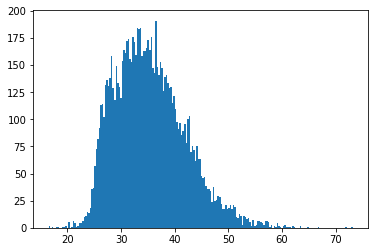

In [4]:
if variables.get('use_efficiency_based_algo_reduction'):
    initial_flop_size_s = sq.sample(lambda: variables['tai_flop_size'](variables['efficiency']), n=10000)
else:
    initial_flop_size_s = sq.sample(variables['tai_flop_size'], n=10000)

initial_flops_p = sq.get_percentiles(initial_flop_size_s)
plt.hist(initial_flop_size_s, bins = 200)
pprint(initial_flops_p)

In [5]:
min_reduction_p = sq.get_percentiles(sq.sample(variables['min_reduction'], n=1000))
min_reduction_p

{1: 2.0,
 5: 2.0,
 10: 2.0,
 20: 2.0,
 30: 2.0,
 40: 2.0,
 50: 2.0,
 60: 2.0,
 70: 2.0,
 80: 2.0,
 90: 2.0,
 95: 2.0,
 99: 2.0}

In [6]:
max_reduction_p = sq.get_percentiles(sq.sample(variables['max_reduction'], n=1000), reverse=True)
max_reduction_p

{99: 5.0,
 95: 5.0,
 90: 5.0,
 80: 5.0,
 70: 5.0,
 60: 5.0,
 50: 5.0,
 40: 5.0,
 30: 5.0,
 20: 5.0,
 10: 5.0,
 5: 5.0,
 1: 5.0}

In [7]:
algo_doubling_rate_min_p = sq.get_percentiles(sq.sample(variables['algo_doubling_rate_min'], n=1000), reverse=True)
algo_doubling_rate_min_p

{99: 0.8346056586644429,
 95: 1.014484430532403,
 90: 1.1255756604756664,
 80: 1.27491517294435,
 70: 1.3498585241389862,
 60: 1.4242067451521445,
 50: 1.50655191099558,
 40: 1.576099976563046,
 30: 1.6601154203815376,
 20: 1.7507433243102304,
 10: 1.8971080146779902,
 5: 2.0205173171474295,
 1: 2.2263483297656412}

In [8]:
algo_doubling_rate_max_p = sq.get_percentiles(sq.sample(variables['algo_doubling_rate_max'], n=1000), reverse=True)
algo_doubling_rate_max_p

{99: 0.5517290274579161,
 95: 0.981971478708201,
 90: 1.2066661402574106,
 80: 1.4642729485985098,
 70: 1.6545703089111792,
 60: 1.8416651025414175,
 50: 1.9657537760612587,
 40: 2.121269583438352,
 30: 2.2845165863678853,
 20: 2.4638828204537964,
 10: 2.7502886446969916,
 5: 3.022007757241472,
 1: 3.3438104356747056}

In [9]:
initial_flops_per_dollar_p = sq.get_percentiles(sq.sample(variables['initial_flops_per_dollar'], n=1000))
initial_flops_per_dollar_p

{1: 18.0,
 5: 18.0,
 10: 18.0,
 20: 18.0,
 30: 18.0,
 40: 18.0,
 50: 18.0,
 60: 18.0,
 70: 18.0,
 80: 18.0,
 90: 18.0,
 95: 18.0,
 99: 18.0}

In [10]:
flops_halving_rate_p = sq.get_percentiles(sq.sample(variables['flops_halving_rate'], n=1000), reverse=True)
flops_halving_rate_p

{99: 1.6808196336732417,
 95: 2.0511045546906903,
 90: 2.2521386139968893,
 80: 2.5487525558459425,
 70: 2.7547666399420163,
 60: 2.9653724615577692,
 50: 3.1513429685185574,
 40: 3.3617294463004326,
 30: 3.589516570442492,
 20: 3.9552184786336753,
 10: 4.50022401599136,
 5: 4.945042839628852,
 1: 6.008684578196173}

In [11]:
max_flops_per_dollar_p = sq.get_percentiles(sq.sample(variables['max_flops_per_dollar'], n=1000))
max_flops_per_dollar_p

{1: 24.0,
 5: 24.0,
 10: 24.0,
 20: 24.0,
 30: 24.0,
 40: 24.0,
 50: 24.0,
 60: 24.0,
 70: 24.0,
 80: 24.0,
 90: 24.0,
 95: 24.0,
 99: 24.0}

In [12]:
initial_pay_p = sq.get_percentiles(sq.sample(variables['initial_pay'], n=1000))
initial_pay_p

{1: 7.1,
 5: 7.1,
 10: 7.1,
 20: 7.1,
 30: 7.1,
 40: 7.1,
 50: 7.1,
 60: 7.1,
 70: 7.1,
 80: 7.442677297872933,
 90: 8.10679874549313,
 95: 8.49993759390077,
 99: 9.072675897837772}

In [13]:
gdp_growth_p = sq.get_percentiles(sq.sample(variables['gdp_growth'], n=1000))
gdp_growth_p

{1: 1.0103877651624447,
 5: 1.0148690619456728,
 10: 1.0168971253580752,
 20: 1.0198881897325167,
 30: 1.021866498866321,
 40: 1.0236318361621,
 50: 1.0252453822504406,
 60: 1.0267844486181896,
 70: 1.028333374466468,
 80: 1.0301350232812017,
 90: 1.0328298129142812,
 95: 1.0346816143155326,
 99: 1.038246575978166}

In [14]:
max_gdp_frac_p = sq.get_percentiles(sq.sample(variables['max_gdp_frac'], n=1000))
max_gdp_frac_p

{1: 2.5471283324340807e-06,
 5: 1.1405819369023477e-05,
 10: 0.00010874445719557475,
 20: 0.0005361846363552748,
 30: 0.0006006021696099155,
 40: 0.0006538122925155266,
 50: 0.0007049609287180828,
 60: 0.0007729976484228726,
 70: 0.0008608799536878589,
 80: 0.0014154164637636083,
 90: 0.002790279571456752,
 95: 0.0050558935486592176,
 99: 0.011479807858082919}

In [15]:
willingness_ramp = variables.get('willingness_ramp', 0)
if willingness_ramp != 0:
    willingness_ramp_p = sq.get_percentiles(sq.sample(willingness_ramp), n=1000)
    pprint(willingness_ramp_p)
else:
    print(0)

0


In [16]:
spend_doubling_time_p = sq.get_percentiles(sq.sample(variables['spend_doubling_time'], n=1000), reverse=True)
spend_doubling_time_p

{99: 1.0027075693329186,
 95: 1.1791680445391146,
 90: 1.3471530149450899,
 80: 1.9026052056996463,
 70: 3.2571849508119586,
 60: 3.627700276693341,
 50: 3.9483098807983055,
 40: 4.265315966944959,
 30: 4.55771876837777,
 20: 4.906634881269449,
 10: 5.308147735445053,
 5: 5.750490677635355,
 1: 6.63375720118344}

In [17]:
nonscaling_delay = variables.get('nonscaling_delay', 0)
if nonscaling_delay != 0:
    nonscaling_delay_p = sq.get_percentiles(np.ceil(sq.sample(nonscaling_delay, n=1000)), reverse=True)
    pprint(nonscaling_delay_p)
else:
    print(0)

{1: 45.0,
 5: 27.0,
 10: 19.0,
 20: 12.200000000000045,
 30: 9.0,
 40: 7.0,
 50: 6.0,
 60: 5.0,
 70: 4.0,
 80: 4.0,
 90: 3.0,
 95: 3.0,
 99: 2.0}


In [18]:
willingness_spend_horizon = variables.get('willingness_spend_horizon', 1)
if willingness_spend_horizon != 1:
    willingness_spend_horizon_p = sq.get_percentiles(sq.sample(willingness_spend_horizon, n=1000))
    pprint(willingness_spend_horizon_p)
else:
    print(1)

1


## GDP Over Time

Text(0, 0.5, 'log GDP')

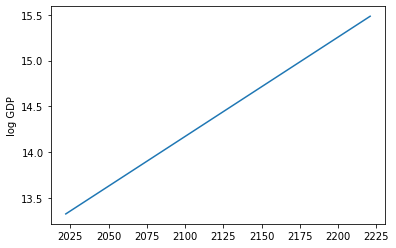

In [19]:
gdp_ = np.array([gdp(initial_gdp=variables['initial_gdp'],
                     gdp_growth=gdp_growth_p[GRAPH_P],
                     year=(y - CURRENT_YEAR)) for y in years])
plt.plot(years, np.log10(gdp_))
plt.ylabel('log GDP')

In [20]:
for y in years:
    print('Year: {} - GDP log 2022$USD {} (~{})'.format(y,
                                                        np.round(np.log10(gdp_[y - CURRENT_YEAR]), 1),
                                                        numerize(gdp_[y - CURRENT_YEAR])))
    

Year: 2022 - GDP log 2022$USD 13.3 (~21 trillion)
Year: 2023 - GDP log 2022$USD 13.3 (~22 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~22 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~23 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~24 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~25 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion)
Year: 2033 - GDP log 2022$USD 13.4 (~28 trillion)
Year: 2034 - GDP log 2022$USD 13.5 (~29 trillion)
Year: 2035 - GDP log 2022$USD 13.5 (~29 trillion)
Year: 2036 - GDP log 2022$USD 13.5 (~30 trillion)
Year: 2037 - GDP log 2022$USD 13.5 (~31 trillion)
Year: 2038 - GDP log 2022$USD 13.5 (~32 trillion)
Year: 2039 - GDP log 2022$USD 13.5 (~33 trillion)
Year: 2040 - GDP log 2022$USD 13.5 (~33 trillion)
Year: 2041 - GDP log 2022$USD 13.5 (~34 trillion)


## Willingness to Pay Over Time

-
-
## 20 ##
Year: 2022 - willingness log 2022$USD per year 7.1 (~13 million)
Year: 2023 - willingness log 2022$USD per year 7.2 (~14 million)
Year: 2024 - willingness log 2022$USD per year 7.2 (~17 million)
Year: 2025 - willingness log 2022$USD per year 7.3 (~19 million)
Year: 2026 - willingness log 2022$USD per year 7.3 (~22 million)
Year: 2027 - willingness log 2022$USD per year 7.4 (~25 million)
Year: 2028 - willingness log 2022$USD per year 7.5 (~29 million)
Year: 2029 - willingness log 2022$USD per year 7.5 (~34 million)
Year: 2030 - willingness log 2022$USD per year 7.6 (~39 million)
Year: 2031 - willingness log 2022$USD per year 7.7 (~45 million)
Year: 2032 - willingness log 2022$USD per year 7.7 (~52 million)
Year: 2033 - willingness log 2022$USD per year 7.8 (~59 million)
Year: 2034 - willingness log 2022$USD per year 7.8 (~68 million)
Year: 2035 - willingness log 2022$USD per year 7.9 (~79 million)
Year: 2036 - willingness log 2022$USD per year 8.0 (~90 million)
Year: 2037 -

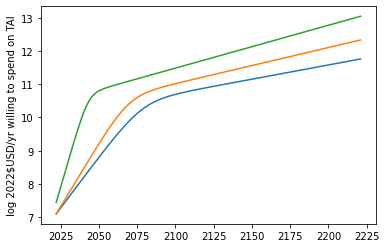

In [21]:
for p in [20, 50, 80]:
    print('-')
    print('-')
    print('## {} ##'.format(p))
    willingness = np.array([willingness_to_pay(initial_gdp=variables['initial_gdp'],
                                               gdp_growth=gdp_growth_p[p],
                                               initial_pay=10 ** initial_pay_p[p],
                                               spend_doubling_time=spend_doubling_time_p[p],
                                               max_gdp_frac=max_gdp_frac_p[p],
                                               year=(y - CURRENT_YEAR)) for y in years])
    for y in years:
        print('Year: {} - willingness log 2022$USD per year {} (~{})'.format(y,
                                                                             np.round(np.log10(willingness[y - CURRENT_YEAR]), 1),
                                                                             numerize(willingness[y - CURRENT_YEAR])))


    plt.plot(years, np.log10(willingness))
plt.ylabel('log 2022$USD/yr willing to spend on TAI')
plt.show()


## FLOPs Needed to Make TAI (Given Algorithmic Progress)

Text(0, 0.5, 'log FLOPs needed to make TAI')

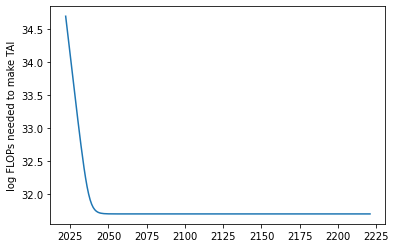

In [22]:
flops_ = np.array([flops_needed(initial_flops=10 ** initial_flops_p[GRAPH_P],
                                doubling_rate=algo_halving_fn(algo_doubling_rate_min_p[GRAPH_P],
                                                              algo_doubling_rate_max_p[GRAPH_P],
                                                              initial_flops_p[GRAPH_P]),
                                possible_reduction=10 ** possible_algo_reduction_fn(min_reduction_p[GRAPH_P],
                                                                                    max_reduction_p[GRAPH_P],
                                                                                    initial_flops_p[GRAPH_P]),
                                year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(flops_))
plt.ylabel('log FLOPs needed to make TAI')


In [23]:
for y in years:
    print('Year: {} - log FLOPs needed for TAI {} (~{})'.format(y,
                                                                np.round(np.log10(flops_[y - CURRENT_YEAR]), 1),
                                                                numerize(flops_[y - CURRENT_YEAR])))

Year: 2022 - log FLOPs needed for TAI 34.7 (~50 decillion)
Year: 2023 - log FLOPs needed for TAI 34.5 (~32 decillion)
Year: 2024 - log FLOPs needed for TAI 34.3 (~20 decillion)
Year: 2025 - log FLOPs needed for TAI 34.1 (~13 decillion)
Year: 2026 - log FLOPs needed for TAI 33.9 (~8 decillion)
Year: 2027 - log FLOPs needed for TAI 33.7 (~5 decillion)
Year: 2028 - log FLOPs needed for TAI 33.5 (~3 decillion)
Year: 2029 - log FLOPs needed for TAI 33.3 (~2 decillion)
Year: 2030 - log FLOPs needed for TAI 33.1 (~1 decillion)
Year: 2031 - log FLOPs needed for TAI 32.9 (~846 nonillion)
Year: 2032 - log FLOPs needed for TAI 32.7 (~553 nonillion)
Year: 2033 - log FLOPs needed for TAI 32.6 (~367 nonillion)
Year: 2034 - log FLOPs needed for TAI 32.4 (~250 nonillion)
Year: 2035 - log FLOPs needed for TAI 32.2 (~176 nonillion)
Year: 2036 - log FLOPs needed for TAI 32.1 (~130 nonillion)
Year: 2037 - log FLOPs needed for TAI 32.0 (~100 nonillion)
Year: 2038 - log FLOPs needed for TAI 31.9 (~82 nonill

## FLOPs per Dollar (Given Declining Costs)

Text(0, 0.5, 'log FLOPs per $1')

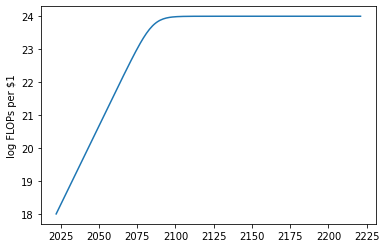

In [24]:
flops_per_dollar_ = np.array([flops_per_dollar(initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                               max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                               halving_rate=flops_halving_rate_p[GRAPH_P],
                                               year=(y - CURRENT_YEAR)) for y in years])
plt.plot(years, np.log10(flops_per_dollar_))
plt.ylabel('log FLOPs per $1')


In [25]:
for y in years:
    print('Year: {} - log {} FLOPs per $ (~{})'.format(y,
                                                       np.round(np.log10(flops_per_dollar_[y - CURRENT_YEAR]), 1),
                                                       numerize(flops_per_dollar_[y - CURRENT_YEAR])))

Year: 2022 - log 18.0 FLOPs per $ (~1000 quadrillion)
Year: 2023 - log 18.1 FLOPs per $ (~1 quintillion)
Year: 2024 - log 18.2 FLOPs per $ (~2 quintillion)
Year: 2025 - log 18.3 FLOPs per $ (~2 quintillion)
Year: 2026 - log 18.4 FLOPs per $ (~2 quintillion)
Year: 2027 - log 18.5 FLOPs per $ (~3 quintillion)
Year: 2028 - log 18.6 FLOPs per $ (~4 quintillion)
Year: 2029 - log 18.7 FLOPs per $ (~5 quintillion)
Year: 2030 - log 18.8 FLOPs per $ (~6 quintillion)
Year: 2031 - log 18.9 FLOPs per $ (~7 quintillion)
Year: 2032 - log 19.0 FLOPs per $ (~9 quintillion)
Year: 2033 - log 19.1 FLOPs per $ (~11 quintillion)
Year: 2034 - log 19.1 FLOPs per $ (~14 quintillion)
Year: 2035 - log 19.2 FLOPs per $ (~17 quintillion)
Year: 2036 - log 19.3 FLOPs per $ (~22 quintillion)
Year: 2037 - log 19.4 FLOPs per $ (~27 quintillion)
Year: 2038 - log 19.5 FLOPs per $ (~34 quintillion)
Year: 2039 - log 19.6 FLOPs per $ (~42 quintillion)
Year: 2040 - log 19.7 FLOPs per $ (~52 quintillion)
Year: 2041 - log 19.

## Max Possible OOM Reduction in TAI FLOP Size

Text(0.5, 0, 'initial FLOP needed for TAI prior to any reduction')

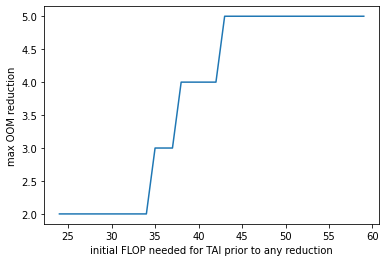

In [26]:
# TODO: Update to include efficiency based
tai_sizes = range(24, 60)
flops_per_dollar_ = np.array([possible_algo_reduction_fn(min_reduction_p[GRAPH_P],
                                                         max_reduction_p[GRAPH_P], t) for t in tai_sizes])
plt.plot(tai_sizes, flops_per_dollar_)
plt.ylabel('max OOM reduction')
plt.xlabel('initial FLOP needed for TAI prior to any reduction')


In [27]:
for t in tai_sizes:
    print('TAI log FLOP {} -> {} OOM reductions possible'.format(t,
                                                                 round(possible_algo_reduction_fn(min_reduction_p[GRAPH_P],
                                                                                                  max_reduction_p[GRAPH_P],
                                                                                                  t), 2)))
          

TAI log FLOP 24 -> 2.0 OOM reductions possible
TAI log FLOP 25 -> 2.0 OOM reductions possible
TAI log FLOP 26 -> 2.0 OOM reductions possible
TAI log FLOP 27 -> 2.0 OOM reductions possible
TAI log FLOP 28 -> 2.0 OOM reductions possible
TAI log FLOP 29 -> 2.0 OOM reductions possible
TAI log FLOP 30 -> 2.0 OOM reductions possible
TAI log FLOP 31 -> 2.0 OOM reductions possible
TAI log FLOP 32 -> 2.0 OOM reductions possible
TAI log FLOP 33 -> 2.0 OOM reductions possible
TAI log FLOP 34 -> 2.0 OOM reductions possible
TAI log FLOP 35 -> 3.0 OOM reductions possible
TAI log FLOP 36 -> 3.0 OOM reductions possible
TAI log FLOP 37 -> 3.0 OOM reductions possible
TAI log FLOP 38 -> 4.0 OOM reductions possible
TAI log FLOP 39 -> 4.0 OOM reductions possible
TAI log FLOP 40 -> 4.0 OOM reductions possible
TAI log FLOP 41 -> 4.0 OOM reductions possible
TAI log FLOP 42 -> 4.0 OOM reductions possible
TAI log FLOP 43 -> 5.0 OOM reductions possible
TAI log FLOP 44 -> 5.0 OOM reductions possible
TAI log FLOP 

## Halving time (years) of compute requirements

Text(0.5, 0, 'initial FLOP needed for TAI prior to any reduction')

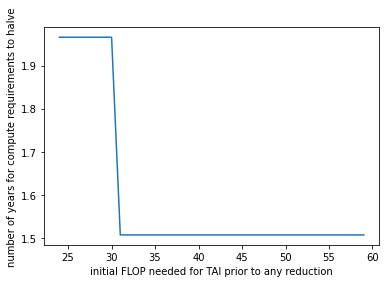

In [28]:
tai_sizes = range(24, 60)
flops_per_dollar_ = np.array([algo_halving_fn(algo_doubling_rate_min_p[GRAPH_P],
                                              algo_doubling_rate_max_p[GRAPH_P],
                                              t) for t in tai_sizes])
plt.plot(tai_sizes, flops_per_dollar_)
plt.ylabel('number of years for compute requirements to halve')
plt.xlabel('initial FLOP needed for TAI prior to any reduction')


In [29]:
for t in tai_sizes:
    print('TAI log FLOP {} -> algo doubling rate {}yrs'.format(t,
                                                               round(algo_halving_fn(algo_doubling_rate_min_p[GRAPH_P],
                                                                                     algo_doubling_rate_max_p[GRAPH_P],
                                                                                     t), 2)))


TAI log FLOP 24 -> algo doubling rate 1.97yrs
TAI log FLOP 25 -> algo doubling rate 1.97yrs
TAI log FLOP 26 -> algo doubling rate 1.97yrs
TAI log FLOP 27 -> algo doubling rate 1.97yrs
TAI log FLOP 28 -> algo doubling rate 1.97yrs
TAI log FLOP 29 -> algo doubling rate 1.97yrs
TAI log FLOP 30 -> algo doubling rate 1.97yrs
TAI log FLOP 31 -> algo doubling rate 1.51yrs
TAI log FLOP 32 -> algo doubling rate 1.51yrs
TAI log FLOP 33 -> algo doubling rate 1.51yrs
TAI log FLOP 34 -> algo doubling rate 1.51yrs
TAI log FLOP 35 -> algo doubling rate 1.51yrs
TAI log FLOP 36 -> algo doubling rate 1.51yrs
TAI log FLOP 37 -> algo doubling rate 1.51yrs
TAI log FLOP 38 -> algo doubling rate 1.51yrs
TAI log FLOP 39 -> algo doubling rate 1.51yrs
TAI log FLOP 40 -> algo doubling rate 1.51yrs
TAI log FLOP 41 -> algo doubling rate 1.51yrs
TAI log FLOP 42 -> algo doubling rate 1.51yrs
TAI log FLOP 43 -> algo doubling rate 1.51yrs
TAI log FLOP 44 -> algo doubling rate 1.51yrs
TAI log FLOP 45 -> algo doubling r

## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP)

Text(0, 0.5, 'log $ needed to buy TAI')

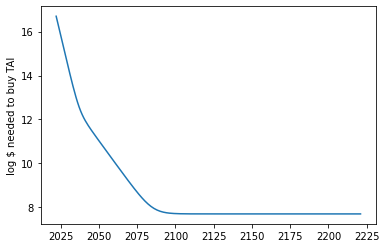

In [30]:
cost_of_tai_ = np.array([cost_of_tai(initial_flops=10 ** initial_flops_p[GRAPH_P],
                                     possible_reduction=10 ** possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], initial_flops_p[GRAPH_P]),
                                     algo_doubling_rate=algo_halving_fn(algo_doubling_rate_min_p[GRAPH_P],
                                                                        algo_doubling_rate_max_p[GRAPH_P],
                                                                        initial_flops_p[GRAPH_P]),
                                     initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                     max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                     flops_halving_rate=flops_halving_rate_p[GRAPH_P],
                                     year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(cost_of_tai_))
plt.ylabel('log $ needed to buy TAI')


In [31]:
for y in years:
    print('Year: {} - log $ {} to buy TAI (~{})'.format(y,
                                                        np.round(np.log10(cost_of_tai_[y - CURRENT_YEAR]), 1),
                                                        numerize(cost_of_tai_[y - CURRENT_YEAR])))

Year: 2022 - log $ 16.7 to buy TAI (~50 quadrillion)
Year: 2023 - log $ 16.4 to buy TAI (~25 quadrillion)
Year: 2024 - log $ 16.1 to buy TAI (~13 quadrillion)
Year: 2025 - log $ 15.8 to buy TAI (~7 quadrillion)
Year: 2026 - log $ 15.5 to buy TAI (~3 quadrillion)
Year: 2027 - log $ 15.2 to buy TAI (~2 quadrillion)
Year: 2028 - log $ 14.9 to buy TAI (~860 trillion)
Year: 2029 - log $ 14.6 to buy TAI (~439 trillion)
Year: 2030 - log $ 14.4 to buy TAI (~226 trillion)
Year: 2031 - log $ 14.1 to buy TAI (~117 trillion)
Year: 2032 - log $ 13.8 to buy TAI (~61 trillion)
Year: 2033 - log $ 13.5 to buy TAI (~33 trillion)
Year: 2034 - log $ 13.3 to buy TAI (~18 trillion)
Year: 2035 - log $ 13.0 to buy TAI (~10 trillion)
Year: 2036 - log $ 12.8 to buy TAI (~6 trillion)
Year: 2037 - log $ 12.6 to buy TAI (~4 trillion)
Year: 2038 - log $ 12.4 to buy TAI (~2 trillion)
Year: 2039 - log $ 12.2 to buy TAI (~2 trillion)
Year: 2040 - log $ 12.1 to buy TAI (~1 trillion)
Year: 2041 - log $ 11.9 to buy TAI (

## FLOPs at Max Spend

Text(0, 0.5, 'max log FLOPs bought given willingness to spend')

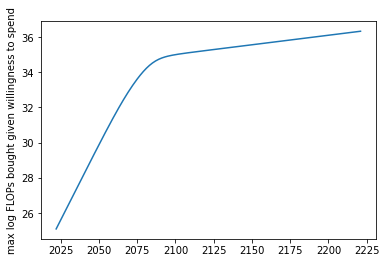

In [32]:
flops_at_max_ = np.array([flops_at_max(initial_gdp=variables['initial_gdp'],
                                       gdp_growth=gdp_growth_p[GRAPH_P],
                                       initial_pay=10 ** initial_pay_p[GRAPH_P],
                                       spend_doubling_time=spend_doubling_time_p[GRAPH_P],
                                       max_gdp_frac=max_gdp_frac_p[GRAPH_P],
                                       initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                       max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                       flops_halving_rate=flops_halving_rate_p[GRAPH_P],
                                       year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(flops_at_max_))
plt.ylabel('max log FLOPs bought given willingness to spend')


In [33]:
for y in years:
    print('Year: {} - max log FLOPs {} (~{} FLOP, ~{} petaFLOP/s-days)'.format(y,
                                                                               np.round(np.log10(flops_at_max_[y - CURRENT_YEAR]), 1),
                                                                               numerize(flops_at_max_[y - CURRENT_YEAR]),
                                                                               log_flop_to_petaflop_sdays(np.log10(flops_at_max_[y - CURRENT_YEAR]))))
    

Year: 2022 - max log FLOPs 25.1 (~13 septillion FLOP, ~145587 petaFLOP/s-days)
Year: 2023 - max log FLOPs 25.3 (~19 septillion FLOP, ~216187 petaFLOP/s-days)
Year: 2024 - max log FLOPs 25.4 (~28 septillion FLOP, ~321017 petaFLOP/s-days)
Year: 2025 - max log FLOPs 25.6 (~41 septillion FLOP, ~476667 petaFLOP/s-days)
Year: 2026 - max log FLOPs 25.8 (~61 septillion FLOP, ~707765 petaFLOP/s-days)
Year: 2027 - max log FLOPs 26.0 (~91 septillion FLOP, ~1050867 petaFLOP/s-days)
Year: 2028 - max log FLOPs 26.1 (~135 septillion FLOP, ~1560232 petaFLOP/s-days)
Year: 2029 - max log FLOPs 26.3 (~200 septillion FLOP, ~2316382 petaFLOP/s-days)
Year: 2030 - max log FLOPs 26.5 (~297 septillion FLOP, ~3438803 petaFLOP/s-days)
Year: 2031 - max log FLOPs 26.6 (~441 septillion FLOP, ~5104778 petaFLOP/s-days)
Year: 2032 - max log FLOPs 26.8 (~655 septillion FLOP, ~7577298 petaFLOP/s-days)
Year: 2033 - max log FLOPs 27.0 (~972 septillion FLOP, ~11246430 petaFLOP/s-days)
Year: 2034 - max log FLOPs 27.2 (~1 oc

## Parameters at Max Spend

In [34]:
for y in years:
    print('Year: {} - max log parameters {} (~{} parameters)'.format(y,
                                                                     np.round(np.log10(flops_at_max_[y - CURRENT_YEAR]) - 12, 1),
                                                                     numerize(10 ** (np.log10(flops_at_max_[y - CURRENT_YEAR]) - 12))))
                                                                     
    

Year: 2022 - max log parameters 13.1 (~13 trillion parameters)
Year: 2023 - max log parameters 13.3 (~19 trillion parameters)
Year: 2024 - max log parameters 13.4 (~28 trillion parameters)
Year: 2025 - max log parameters 13.6 (~41 trillion parameters)
Year: 2026 - max log parameters 13.8 (~61 trillion parameters)
Year: 2027 - max log parameters 14.0 (~91 trillion parameters)
Year: 2028 - max log parameters 14.1 (~135 trillion parameters)
Year: 2029 - max log parameters 14.3 (~200 trillion parameters)
Year: 2030 - max log parameters 14.5 (~297 trillion parameters)
Year: 2031 - max log parameters 14.6 (~441 trillion parameters)
Year: 2032 - max log parameters 14.8 (~655 trillion parameters)
Year: 2033 - max log parameters 15.0 (~972 trillion parameters)
Year: 2034 - max log parameters 15.2 (~1 quadrillion parameters)
Year: 2035 - max log parameters 15.3 (~2 quadrillion parameters)
Year: 2036 - max log parameters 15.5 (~3 quadrillion parameters)
Year: 2037 - max log parameters 15.7 (~5 qu

## Chance of Non-scaling Delay

Text(0, 0.5, 'chance of non-scaling delay by year')

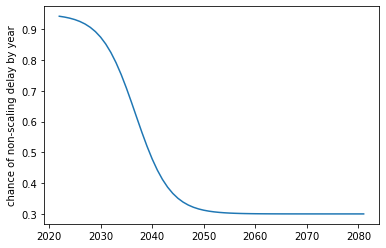

In [35]:
p_nonscaling_delay_ = np.array([p_nonscaling_delay(variables.get('initial_chance_of_nonscaling_issue', 0),
                                                   variables.get('final_chance_of_nonscaling_issue', 0),
                                                   year=y,
                                                   max_year=variables.get('nonscaling_issue_bottom_year', 0)) for y in years])

plt.plot(years[:60], p_nonscaling_delay_[:60])
plt.ylabel('chance of non-scaling delay by year')


In [36]:
for y in years:
    print('Year: {} - p(nonscaling delay) = {}%'.format(y,
                                                        np.round(p_nonscaling_delay_[y - CURRENT_YEAR] * 100, 1)))

Year: 2022 - p(nonscaling delay) = 94.2%
Year: 2023 - p(nonscaling delay) = 94.0%
Year: 2024 - p(nonscaling delay) = 93.6%
Year: 2025 - p(nonscaling delay) = 93.2%
Year: 2026 - p(nonscaling delay) = 92.5%
Year: 2027 - p(nonscaling delay) = 91.7%
Year: 2028 - p(nonscaling delay) = 90.6%
Year: 2029 - p(nonscaling delay) = 89.2%
Year: 2030 - p(nonscaling delay) = 87.5%
Year: 2031 - p(nonscaling delay) = 85.2%
Year: 2032 - p(nonscaling delay) = 82.5%
Year: 2033 - p(nonscaling delay) = 79.1%
Year: 2034 - p(nonscaling delay) = 75.3%
Year: 2035 - p(nonscaling delay) = 70.9%
Year: 2036 - p(nonscaling delay) = 66.2%
Year: 2037 - p(nonscaling delay) = 61.4%
Year: 2038 - p(nonscaling delay) = 56.6%
Year: 2039 - p(nonscaling delay) = 52.0%
Year: 2040 - p(nonscaling delay) = 47.9%
Year: 2041 - p(nonscaling delay) = 44.3%
Year: 2042 - p(nonscaling delay) = 41.2%
Year: 2043 - p(nonscaling delay) = 38.7%
Year: 2044 - p(nonscaling delay) = 36.7%
Year: 2045 - p(nonscaling delay) = 35.1%
Year: 2046 - p(n

## Run Model

In [37]:
def run_model(initial_gdp_, tai_flop_size_, nonscaling_delay_, algo_doubling_rate_,
              possible_algo_reduction_, initial_flops_per_dollar_, flops_halving_rate_,
              max_flops_per_dollar_, initial_pay_, gdp_growth_, max_gdp_frac_,
              willingness_ramp_, spend_doubling_time_, initial_chance_of_nonscaling_issue_,
              final_chance_of_nonscaling_issue_, nonscaling_issue_bottom_year_,
              willingness_spend_horizon_, print_diagnostic):
    queue_tai_year = 99999
    plt.ioff()
    if print_diagnostic:
        cost_of_tai_collector = []
        willingness_collector = []
    
    if print_diagnostic:
        print('It takes {} log FLOPs (~{}) for transformative capabilities.'.format(np.round(tai_flop_size_, 1),
                                                                                    numerize(10 ** tai_flop_size_)))
        print('Every {} years algorithms get 2x better, with {} log reductions possible.'.format(np.round(algo_doubling_rate_, 1),
                                                                                                 np.round(possible_algo_reduction_, 1)))
        print(('FLOPs start at a cost of {} log FLOPs (~{}) per 2022$USD. Every {} years they get ' +
               '2x cheaper, to a maximum of {} log FLOPs (~{}) per 2022$USD.').format(np.round(math.log10(initial_flops_per_dollar_), 1),
                                                                               numerize(initial_flops_per_dollar_),
                                                                               np.round(flops_halving_rate_, 1),
                                                                               np.round(math.log10(max_flops_per_dollar_), 1),
                                                                               numerize(max_flops_per_dollar_)))
        print(('We are willing to pay {} log 2022$USD (~{}) and this increases by {}x per year to a max of {}% of GDP. ' +
               'GDP grows at a rate of {}x per year.').format(np.round(math.log10(initial_pay_), 1),
                                                              numerize(initial_pay_),
                                                              np.round(spend_doubling_time_, 1),
                                                              np.round(max_gdp_frac_, 4),
                                                              np.round(gdp_growth_, 3)))
        if willingness_ramp_ < 1:
            print('In this simulation, if we are {}% of the way to paying for TAI, we will ramp to paying for TAI.'.format(np.round(willingness_ramp_ * 100)))

        if willingness_spend_horizon_ > 1:
            print('We are willing to spend over {} years to make TAI'.format(willingness_spend_horizon_))
            
        print(('If a non-scaling delay happens, it will take an additional {} years to produce TAI due' +
               ' to issues unrelated to scaling FLOP').format(np.round(nonscaling_delay_, 1)))
        print('---')
    
    tai_created = False
    is_nonscaling_issue = None
    for y in years:
        if not tai_created:
            flops_needed_ = flops_needed(initial_flops=10 ** tai_flop_size_,
                                         doubling_rate=algo_doubling_rate_,
                                         possible_reduction=10 ** possible_algo_reduction_,
                                         year=(y - CURRENT_YEAR))
            
            flops_per_dollar_ = flops_per_dollar(initial_flops_per_dollar=initial_flops_per_dollar_,
                                                 max_flops_per_dollar=max_flops_per_dollar_,
                                                 halving_rate=flops_halving_rate_,
                                                 year=(y - CURRENT_YEAR))
            
            if flops_per_dollar_ > 10 ** 200 or flops_needed_ > 10 ** 200:
                flops_needed_ = int(flops_needed_)
                flops_per_dollar_ = int(flops_per_dollar_)
                cost_of_tai_ = flops_needed_ // flops_per_dollar_
            else:
                cost_of_tai_ = flops_needed_ / flops_per_dollar_
            
            willingness_ = willingness_to_pay(initial_gdp=initial_gdp_,
                                              gdp_growth=gdp_growth_,
                                              initial_pay=initial_pay_,
                                              spend_doubling_time=spend_doubling_time_,
                                              max_gdp_frac=max_gdp_frac_,
                                              year=(y - CURRENT_YEAR))
            
            if flops_per_dollar_ > 10 ** 200:
                willingness_ = int(willingness_)
            if willingness_ > 10 ** 200:
                flops_per_dollar_ = int(flops_per_dollar_)
            
            if print_diagnostic:
                cost_of_tai_collector.append(cost_of_tai_)
                willingness_collector.append(willingness_)
            
            total_compute_ = willingness_ * flops_per_dollar_
            
            if print_diagnostic:
                out_str = ('Year: {} - {} max log FLOP ({}) available - TAI takes {} log FLOP ({}) - ' +
                           'log $ {} to buy TAI ({}) vs. willingness to pay log $ {} ({}) - {} log FLOPS per $ ({})')
                print(out_str.format(y,
                                     np.round(math.log10(total_compute_), 1),
                                     numerize(total_compute_),
                                     np.round(math.log10(flops_needed_), 1),
                                     numerize(flops_needed_),
                                     np.round(math.log10(cost_of_tai_), 1),
                                     numerize(cost_of_tai_),
                                     np.round(math.log10(willingness_), 1),
                                     numerize(willingness_),
                                     np.round(math.log10(flops_per_dollar_), 1),
                                     numerize(flops_per_dollar_)))
            
            if cost_of_tai_ > 10 ** 200:
                spend_tai_years = int(cost_of_tai_) // int(willingness_)
            else:
                spend_tai_years = cost_of_tai_ / willingness_
                
            if not is_nonscaling_issue and queue_tai_year < 99999 and print_diagnostic:
                print('-$- {}/{}'.format(y, queue_tai_year))
            if (cost_of_tai_ * willingness_ramp_) <= willingness_ or y >= queue_tai_year:
                if is_nonscaling_issue is None:
                    p_nonscaling_delay_ = p_nonscaling_delay(initial_chance_of_nonscaling_issue_,
                                                             final_chance_of_nonscaling_issue_,
                                                             year=y,
                                                             max_year=nonscaling_issue_bottom_year_)
                    is_nonscaling_issue = sq.event(p_nonscaling_delay_)
                    nonscaling_countdown = nonscaling_delay_
                    if print_diagnostic:
                        print('-- {} p_nonscaling_issue={}'.format('Nonscaling delay occured' if is_nonscaling_issue else 'Nonscaling issue did not occur',
                                                                   np.round(p_nonscaling_delay_, 4)))
                
                if not is_nonscaling_issue or nonscaling_countdown <= 0.1:
                    if print_diagnostic:
                        print('--- /!\ TAI CREATED in {}'.format(y))
                        plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
                    return y
                else:
                    if print_diagnostic:
                        print('/!\ FLOPs for TAI sufficient but needs {} more years to solve non-scaling issues'.format(np.round(nonscaling_countdown, 1)))
                    nonscaling_countdown -= 1
            elif (not is_nonscaling_issue and willingness_spend_horizon_ > 1 and
                  spend_tai_years <= willingness_spend_horizon_ and y + math.ceil(spend_tai_years) < queue_tai_year):
                queue_tai_year = y + math.ceil(spend_tai_years)
                if print_diagnostic:
                    print('-$- We have enough spend to make TAI in {} years (in {}) if sustained.'.format(math.ceil(spend_tai_years),
                                                                                                          queue_tai_year))
                
    if not tai_created:
        if print_diagnostic:
            print('--- :/ TAI NOT CREATED BEFORE {}'.format(MAX_YEAR + 1))
            plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
        return MAX_YEAR + 1
    
    
def define_event(verbose=False):
    if variables.get('use_efficiency_based_algo_reduction'):
        efficiency = sq.sample(variables['efficiency'])
        tai_flop_size_ = sq.sample(lambda: variables['tai_flop_size'](efficiency=sq.const(efficiency),
                                                                      debug=verbose))
    else:
        tai_flop_size_ = sq.sample(variables['tai_flop_size'])

    if tai_flop_size_ > 300:
        tai_flop_size_ = int(tai_flop_size_) # Handle overflow errors
    
    algo_doubling_rate_ = algo_halving_fn(sq.sample(variables['algo_doubling_rate_min']),
                                          sq.sample(variables['algo_doubling_rate_max']),
                                          tai_flop_size_)
    
    if variables.get('use_efficiency_based_algo_reduction'):
        possible_algo_reduction_ = possible_algo_reduction_fn(efficiency, efficiency, tai_flop_size_)
        if variables.get('efficiency_based_additional_reduction'):
            possible_algo_reduction_ += sq.sample(variables.get('efficiency_based_additional_reduction'))
    else:
        possible_algo_reduction_ = possible_algo_reduction_fn(sq.sample(variables['min_reduction']),
                                                              sq.sample(variables['max_reduction']),
                                                              tai_flop_size_)
    
    initial_flops_per_dollar_ = 10 ** sq.sample(variables['initial_flops_per_dollar'])
    flops_halving_rate_ = sq.sample(variables['flops_halving_rate'])
    max_flops_per_dollar_ = 10 ** sq.sample(variables['max_flops_per_dollar'])
    initial_pay_ = 10 ** sq.sample(variables['initial_pay'])
    gdp_growth_ = sq.sample(variables['gdp_growth'])
    max_gdp_frac_ = sq.sample(variables['max_gdp_frac'])
    
    willingness_ramp_happens = sq.event_occurs(variables.get('p_willingness_ramp', 0))
    if willingness_ramp_happens:
        willingness_ramp_ = sq.sample(variables.get('willingness_ramp', 1))
    else:
        willingness_ramp_ = 1
    
    initial_gdp_ = variables['initial_gdp']
    spend_doubling_time_ = sq.sample(variables['spend_doubling_time'])
    nonscaling_delay_ = sq.sample(variables.get('nonscaling_delay', sq.const(0)))
    initial_chance_of_nonscaling_issue_ = variables.get('initial_chance_of_nonscaling_issue', 0)
    final_chance_of_nonscaling_issue_ = variables.get('final_chance_of_nonscaling_issue', 0)
    nonscaling_issue_bottom_year_ = variables.get('nonscaling_issue_bottom_year', 0)
    willingness_spend_horizon_ = int(sq.sample(variables.get('willingness_spend_horizon', sq.const(1))))
    
    tai_year = run_model(initial_gdp_=initial_gdp_,
                         tai_flop_size_=tai_flop_size_,
                         nonscaling_delay_=nonscaling_delay_,
                         algo_doubling_rate_=algo_doubling_rate_,
                         possible_algo_reduction_=possible_algo_reduction_,
                         initial_flops_per_dollar_=initial_flops_per_dollar_,
                         flops_halving_rate_=flops_halving_rate_,
                         max_flops_per_dollar_=max_flops_per_dollar_,
                         initial_pay_=initial_pay_,
                         gdp_growth_=gdp_growth_,
                         max_gdp_frac_=max_gdp_frac_,
                         willingness_ramp_=willingness_ramp_,
                         spend_doubling_time_=spend_doubling_time_,
                         initial_chance_of_nonscaling_issue_=initial_chance_of_nonscaling_issue_,
                         final_chance_of_nonscaling_issue_=final_chance_of_nonscaling_issue_,
                         nonscaling_issue_bottom_year_=nonscaling_issue_bottom_year_,
                         willingness_spend_horizon_=willingness_spend_horizon_,
                         print_diagnostic=verbose)
    
    return {'tai_year': tai_year,
            'initial_gdp': initial_gdp_,
            'tai_flop_size': tai_flop_size_,
            'nonscaling_delay': nonscaling_delay_,
            'algo_doubling_rte': algo_doubling_rate_,
            'possible_algo_reduction': possible_algo_reduction_,
            'initial_flops_per_dollar': initial_flops_per_dollar_,
            'flops_halving_rate': flops_halving_rate_,
            'max_flops_per_dollar': max_flops_per_dollar_,
            'initial_pay': initial_pay_,
            'gdp_growth': gdp_growth_,
            'max_gdp_frac': max_gdp_frac_,
            'willingness_ramp_': willingness_ramp_,
            'spend_doubling_time_': spend_doubling_time_,
            'initial_chance_of_nonscaling_issue': initial_chance_of_nonscaling_issue_,
            'final_chance_of_nonscaling_issue': final_chance_of_nonscaling_issue_,
            'nonscaling_issue_bottom_year': nonscaling_issue_bottom_year_,
            'willingness_spend_horizon_': willingness_spend_horizon_}

print('Loaded')


Loaded


Anchor debug:
-- Assume human brain in inference takes 16.1 log FLOP
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -1.7 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.24
-- Assume FLOPs per param per sec of 1.9
-- 30.0 = 16.1 + 0 + -1.7 + 0 + 12 - 1.24 * 11.2 + 1.24 * (16.1 + 0 - 1.9)
-- 30.0 after Bayes update
-
It takes 30.0 log FLOPs (~971 octillion) for transformative capabilities.
Every 2.6 years algorithms get 2x better, with 0.6 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 5.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.6x per year to a max of 0.0005% of GDP. GDP grows at a rate of 1.038x per year.
If a non-scaling delay happens, it will take an additional 3.3 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 202

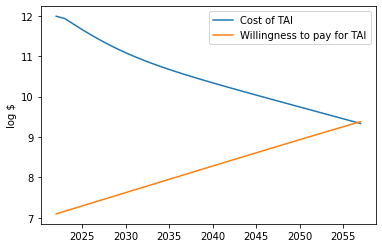

{'tai_year': 2057,
 'initial_gdp': 21300000000000.0,
 'tai_flop_size': 29.98730413571922,
 'nonscaling_delay': 3.3400429340464295,
 'algo_doubling_rte': 2.6390317882113257,
 'possible_algo_reduction': 0.614812276885099,
 'initial_flops_per_dollar': 1000000000000000000,
 'flops_halving_rate': 5.173179683136143,
 'max_flops_per_dollar': 1000000000000000000000000,
 'initial_pay': 12589254.117941663,
 'gdp_growth': 1.0375238547148733,
 'max_gdp_frac': 0.0004962784595854313,
 'willingness_ramp_': 1,
 'spend_doubling_time_': 4.563410568361982,
 'initial_chance_of_nonscaling_issue': 0.95,
 'final_chance_of_nonscaling_issue': 0.3,
 'nonscaling_issue_bottom_year': 2050,
 'willingness_spend_horizon_': 1}

In [38]:
define_event(verbose=True)

## RUN 1 ##
Anchor debug:
-- Assume human brain in inference takes 23.7 log FLOP
-- Add 2.0 log FLOP for efficiency
-- Assume a transformative model takes -1.4 log FLOP compared to human
-- Assume a horizon length of 0.5
-- Assume a scaling exponent of 1.189
-- Assume FLOPs per param per sec of 1.5
-- 52.1 = 23.7 + 2.0 + -1.4 + 0.5 + 12 - 1.189 * 11.2 + 1.189 * (23.7 + 2.0 - 1.5)
-- 52.1 after Bayes update
-
It takes 52.1 log FLOPs (~14 quintillion decillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 2.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.3x per year to a max of 0.0008% of GDP. GDP grows at a rate of 1.026x per year.
If a non-scaling delay happens, it will take an additional 3.0 years to produce TAI due to issues unr

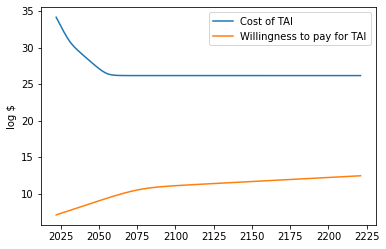

## RUN 2 ##
Anchor debug:
-- Assume human brain in inference takes 14.4 log FLOP
-- Add 2.5 log FLOP for efficiency
-- Assume a transformative model takes -0.4 log FLOP compared to human
-- Assume a horizon length of 9.4
-- Assume a scaling exponent of 0.488
-- Assume FLOPs per param per sec of 1.8
-- 39.7 = 14.4 + 2.5 + -0.4 + 9.4 + 12 - 0.488 * 11.2 + 0.488 * (14.4 + 2.5 - 1.8)
-- 39.7 after Bayes update
-
It takes 39.7 log FLOPs (~5 million decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 2.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.3x per year to a max of 0.0006% of GDP. GDP grows at a rate of 1.034x per year.
If a non-scaling delay happens, it will take an additional 4.7 years to produce TAI due to issues unrelate

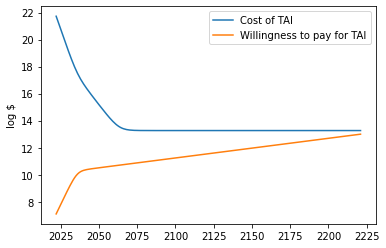

## RUN 3 ##
Anchor debug:
-- Assume human brain in inference takes 15.7 log FLOP
-- Add 1.6 log FLOP for efficiency
-- Assume a transformative model takes 0.1 log FLOP compared to human
-- Assume a horizon length of 6.3
-- Assume a scaling exponent of 1.132
-- Assume FLOPs per param per sec of 1.4
-- 41.2 = 15.7 + 1.6 + 0.1 + 6.3 + 12 - 1.132 * 11.2 + 1.132 * (15.7 + 1.6 - 1.4)
-- 41.2 after Bayes update
-
It takes 41.2 log FLOPs (~147 million decillion) for transformative capabilities.
Every 1.3 years algorithms get 2x better, with 1.7 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.7x per year to a max of 0.0026% of GDP. GDP grows at a rate of 1.025x per year.
If a non-scaling delay happens, it will take an additional 7.2 years to produce TAI due to issues unrelate

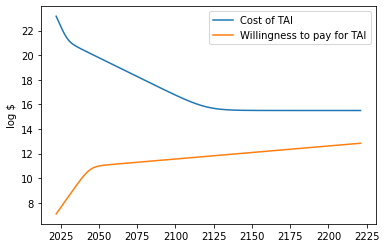

## RUN 4 ##
Anchor debug:
-- Assume human brain in inference takes 12.2 log FLOP
-- Add 1.7 log FLOP for efficiency
-- Assume a transformative model takes -2.4 log FLOP compared to human
-- Assume a horizon length of 2.4
-- Assume a scaling exponent of 1.21
-- Assume FLOPs per param per sec of 1.2
-- 27.7 = 12.2 + 1.7 + -2.4 + 2.4 + 12 - 1.21 * 11.2 + 1.21 * (12.2 + 1.7 - 1.2)
-- 27.7 after Bayes update
-
It takes 27.7 log FLOPs (~5 octillion) for transformative capabilities.
Every 1.9 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 5.2x per year to a max of 0.0027% of GDP. GDP grows at a rate of 1.003x per year.
If a non-scaling delay happens, it will take an additional 5.0 years to produce TAI due to issues unrelated to scalin

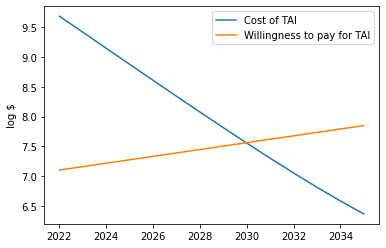

## RUN 5 ##
Anchor debug:
-- Assume human brain in inference takes 15.5 log FLOP
-- Add 1.3 log FLOP for efficiency
-- Assume a transformative model takes -0.1 log FLOP compared to human
-- Assume a horizon length of 4.8
-- Assume a scaling exponent of 1.123
-- Assume FLOPs per param per sec of 1.4
-- 38.1 = 15.5 + 1.3 + -0.1 + 4.8 + 12 - 1.123 * 11.2 + 1.123 * (15.5 + 1.3 - 1.4)
-- 38.1 after Bayes update
-
It takes 38.1 log FLOPs (~136 thousand decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.2x per year to a max of 0.001% of GDP. GDP grows at a rate of 1.023x per year.
If a non-scaling delay happens, it will take an additional 5.4 years to produce TAI due to issues unrela

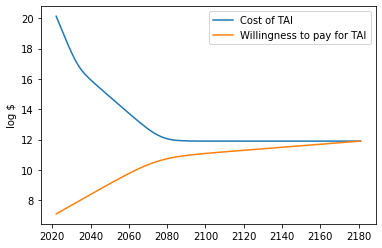

In [39]:
for i in range(5):
    print('## RUN {} ##'.format(i + 1))
    define_event(verbose=True)

In [40]:
tai_years = bayes.bayesnet(define_event,
                           find=lambda e: e['tai_year'],
                           verbose=True,
                           raw=True,
                           n=RUNS)

Checking cache...
Generating Bayes net...


100%|██████████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 313.20it/s]

...Generated
Caching...
...Cached


In [41]:
out = sq.get_percentiles(tai_years)
[str(o[0]) + '%: ' + (str(int(o[1])) if o[1] < MAX_YEAR else '>' + str(MAX_YEAR)) for o in out.items()]

# NOTE: Ajeya's numbers should output something very close to:
# '5%': 2027,
# '10%: 2031',
# '20%: 2037',
# '30%: 2042',
# '40%: 2047',
# '50%: 2053',
# '60%: 2061',
# '70%: 2073',
# '80%: >2100',
# '90%: >2100',
# '95%: >2100'

# My latest numbers (2022 Aug 27 8:43PM CT):
# '1%: 2024',
# '5%: 2027',
# '10%: 2029',
# '20%: 2033',
# '30%: 2038',
# '40%: 2045',
# '50%: 2054',
# '60%: 2064',
# '70%: 2079',
# '80%: 2116',
# '90%: >2222',
# '95%: >2222',
# '99%: >2222']


['1%: 2026',
 '5%: 2031',
 '10%: 2035',
 '20%: 2041',
 '30%: 2048',
 '40%: 2057',
 '50%: 2068',
 '60%: 2087',
 '70%: 2183',
 '80%: >2222',
 '90%: >2222',
 '95%: >2222',
 '99%: >2222']

In [42]:
[str(o[0]) + '%: ' + (str(int(o[1]) - CURRENT_YEAR) if o[1] < MAX_YEAR else '>' + str(MAX_YEAR - CURRENT_YEAR)) + ' years from now' for o in out.items()]


['1%: 4 years from now',
 '5%: 9 years from now',
 '10%: 13 years from now',
 '20%: 19 years from now',
 '30%: 26 years from now',
 '40%: 35 years from now',
 '50%: 46 years from now',
 '60%: 65 years from now',
 '70%: 161 years from now',
 '80%: >200 years from now',
 '90%: >200 years from now',
 '95%: >200 years from now',
 '99%: >200 years from now']

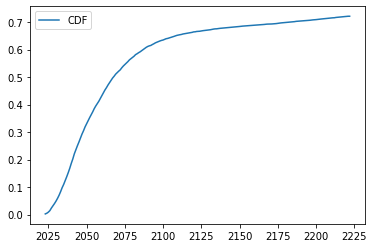

In [43]:
tai_years_ = np.array([MAX_YEAR + 1 if t > MAX_YEAR else t for t in tai_years])
count, bins_count = np.histogram(tai_years_, bins=(MAX_YEAR - CURRENT_YEAR))
bins = np.round(np.array([b for b in bins_count[1:] if b <= MAX_YEAR]))
pdf = count / sum(count)
cdf = np.cumsum(pdf)

plt.plot(bins, cdf[:len(bins)], label='CDF')
plt.legend()

In [109]:
d_ = dict(zip(years, cdf[:len(bins)]))

def bin_tai_yrs(low=None, hi=None):
    low = CURRENT_YEAR if low is None else low
    out = 1 - d_[low] if hi is None else d_[hi] - d_[low]
    return round(out * 100, 1)

print('<2024: {}%'.format(bin_tai_yrs(hi=2024)))
print('2025-2029: {}%'.format(bin_tai_yrs(2025, 2029)))
print('2030-2039: {}%'.format(bin_tai_yrs(2030, 2039)))
print('2040-2049: {}%'.format(bin_tai_yrs(2040, 2049)))
print('2050-2059: {}%'.format(bin_tai_yrs(2050, 2059)))
print('2060-2069: {}%'.format(bin_tai_yrs(2060, 2069)))
print('2070-2079: {}%'.format(bin_tai_yrs(2070, 2079)))
print('2080-2089: {}%'.format(bin_tai_yrs(2080, 2089)))
print('2090-2099: {}%'.format(bin_tai_yrs(2090, 2099)))
print('2100-2149: {}%'.format(bin_tai_yrs(2100, 2149)))
print('2149-2199: {}%'.format(bin_tai_yrs(2149, 2199)))
print('>2200: {}%'.format(bin_tai_yrs(low=2220)))

<2024: 0.6%
2025-2029: 3.4%
2030-2039: 12.7%
2040-2049: 12.8%
2050-2059: 9.1%
2060-2069: 7.4%
2070-2079: 5.0%
2080-2089: 3.6%
2090-2099: 2.1%
2100-2149: 4.8%
2149-2199: 2.5%
>2200: 27.9%


In [45]:
def print_chance_tai_by_year(data, year_target):
    return '{}% chance of TAI by EOY {}'.format(int(np.round(sum([1 if y <= year_target else 0 for y in data]) / len(data) * 100, 0)),
                                                year_target)
    
print('## Within <1 years')
print_chance_tai_by_year(tai_years, 2022)


## Within <1 years


'0% chance of TAI by EOY 2022'

In [46]:
print('## Within <1 years')
print_chance_tai_by_year(tai_years, 2023)

## Within <1 years


'0% chance of TAI by EOY 2023'

In [47]:
print_chance_tai_by_year(tai_years, 2024)

'0% chance of TAI by EOY 2024'

In [48]:
print_chance_tai_by_year(tai_years, 2025)

'1% chance of TAI by EOY 2025'

In [49]:
print('## Within 5 years')
print_chance_tai_by_year(tai_years, 2027)

## Within 5 years


'2% chance of TAI by EOY 2027'

In [50]:
print_chance_tai_by_year(tai_years, 2029)

'4% chance of TAI by EOY 2029'

In [51]:
print_chance_tai_by_year(tai_years, 2030)

'5% chance of TAI by EOY 2030'

In [52]:
print('## Within 10 years')
print_chance_tai_by_year(tai_years, 2032)

## Within 10 years


'7% chance of TAI by EOY 2032'

In [53]:
# Holden benchmarks from https://www.cold-takes.com/biological-anchors-is-about-bounding-not-pinpointing-ai-timelines/#bio-anchors-as-a-way-of-bounding-ai-timelines
print('## Within 14 years (Holden benchmark - 10%-50%, Holden: 10%)')
print_chance_tai_by_year(tai_years, 2036)


## Within 14 years (Holden benchmark - 10%-50%, Holden: 10%)


'12% chance of TAI by EOY 2036'

In [54]:
print('## Within 15 years')
print_chance_tai_by_year(tai_years, 2037)

## Within 15 years


'14% chance of TAI by EOY 2037'

In [55]:
print_chance_tai_by_year(tai_years, 2040)

'19% chance of TAI by EOY 2040'

In [56]:
print('## Within 20 years')
print_chance_tai_by_year(tai_years, 2042)

## Within 20 years


'22% chance of TAI by EOY 2042'

In [57]:
print('## Within 25 years')
print_chance_tai_by_year(tai_years, 2047)

## Within 25 years


'29% chance of TAI by EOY 2047'

In [58]:
print_chance_tai_by_year(tai_years, 2050)

'33% chance of TAI by EOY 2050'

In [59]:
print('## Within 38 years (Holden benchmark - 25%-75%, Holden: 50%)')
print_chance_tai_by_year(tai_years, 2060)

## Within 38 years (Holden benchmark - 25%-75%, Holden: 50%)


'43% chance of TAI by EOY 2060'

In [60]:
print('## Within 48 years (Carlsmith benchmark - Carlsmith: 50%)')
print_chance_tai_by_year(tai_years, 2070)

## Within 48 years (Carlsmith benchmark - Carlsmith: 50%)


'52% chance of TAI by EOY 2070'

In [61]:
print('## Within 50 years')
print_chance_tai_by_year(tai_years, 2072)

## Within 50 years


'53% chance of TAI by EOY 2072'

In [62]:
print('## Within my personal expected lifespan')
print_chance_tai_by_year(tai_years, 2078)

## Within my personal expected lifespan


'56% chance of TAI by EOY 2078'

In [63]:
print('## Within 75 years')
print_chance_tai_by_year(tai_years, 2097)

## Within 75 years


'63% chance of TAI by EOY 2097'

In [64]:
print('## Within 78 years (Holden benchmark - 33%-90%, Holden: 66%)')
print_chance_tai_by_year(tai_years, 2100)

## Within 78 years (Holden benchmark - 33%-90%, Holden: 66%)


'63% chance of TAI by EOY 2100'

In [65]:
print('## Within 100 years')
print_chance_tai_by_year(tai_years, 2122)

## Within 100 years


'67% chance of TAI by EOY 2122'

In [66]:
print('## Within 200 years')
print_chance_tai_by_year(tai_years, 2222)

## Within 200 years


'72% chance of TAI by EOY 2222'

<string>:109: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

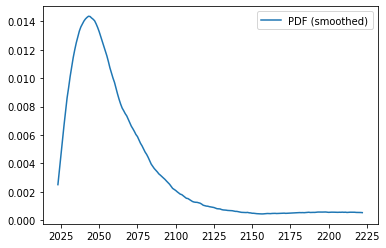

In [67]:
pdf_smoothed = savitzky_golay(pdf[:len(bins)], 51, 3)
plt.plot(bins, pdf_smoothed, label='PDF (smoothed)')
plt.legend()
plt.show()

In [68]:
cdf[:len(bins)]

array([0.0025, 0.005 , 0.009 , 0.0146, 0.0239, 0.0317, 0.04  , 0.0489,
       0.059 , 0.0702, 0.0832, 0.0976, 0.1095, 0.1231, 0.1375, 0.1524,
       0.1685, 0.1863, 0.2024, 0.2211, 0.2358, 0.2503, 0.2638, 0.2785,
       0.2926, 0.3049, 0.3187, 0.3301, 0.3409, 0.3524, 0.3627, 0.3734,
       0.3851, 0.3948, 0.4035, 0.412 , 0.4222, 0.4321, 0.4425, 0.4529,
       0.4614, 0.471 , 0.4796, 0.4881, 0.4963, 0.5029, 0.5104, 0.516 ,
       0.5213, 0.5261, 0.5335, 0.5399, 0.5451, 0.5507, 0.556 , 0.5623,
       0.5666, 0.571 , 0.5755, 0.5813, 0.5845, 0.5884, 0.5916, 0.5957,
       0.6001, 0.6044, 0.6079, 0.6111, 0.6133, 0.6148, 0.6181, 0.6209,
       0.6243, 0.6267, 0.6287, 0.6312, 0.6331, 0.6345, 0.6369, 0.6392,
       0.6403, 0.642 , 0.6439, 0.6457, 0.6474, 0.6494, 0.6513, 0.6526,
       0.6537, 0.6547, 0.6564, 0.6574, 0.6583, 0.6592, 0.6602, 0.6615,
       0.6623, 0.664 , 0.6644, 0.6656, 0.6664, 0.6676, 0.6684, 0.669 ,
       0.6697, 0.6706, 0.6712, 0.6719, 0.6731, 0.6742, 0.675 , 0.6752,
      

In [69]:
pdf[:len(bins)]

array([0.0025, 0.0025, 0.004 , 0.0056, 0.0093, 0.0078, 0.0083, 0.0089,
       0.0101, 0.0112, 0.013 , 0.0144, 0.0119, 0.0136, 0.0144, 0.0149,
       0.0161, 0.0178, 0.0161, 0.0187, 0.0147, 0.0145, 0.0135, 0.0147,
       0.0141, 0.0123, 0.0138, 0.0114, 0.0108, 0.0115, 0.0103, 0.0107,
       0.0117, 0.0097, 0.0087, 0.0085, 0.0102, 0.0099, 0.0104, 0.0104,
       0.0085, 0.0096, 0.0086, 0.0085, 0.0082, 0.0066, 0.0075, 0.0056,
       0.0053, 0.0048, 0.0074, 0.0064, 0.0052, 0.0056, 0.0053, 0.0063,
       0.0043, 0.0044, 0.0045, 0.0058, 0.0032, 0.0039, 0.0032, 0.0041,
       0.0044, 0.0043, 0.0035, 0.0032, 0.0022, 0.0015, 0.0033, 0.0028,
       0.0034, 0.0024, 0.002 , 0.0025, 0.0019, 0.0014, 0.0024, 0.0023,
       0.0011, 0.0017, 0.0019, 0.0018, 0.0017, 0.002 , 0.0019, 0.0013,
       0.0011, 0.001 , 0.0017, 0.001 , 0.0009, 0.0009, 0.001 , 0.0013,
       0.0008, 0.0017, 0.0004, 0.0012, 0.0008, 0.0012, 0.0008, 0.0006,
       0.0007, 0.0009, 0.0006, 0.0007, 0.0012, 0.0011, 0.0008, 0.0002,
      

<string>:109: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

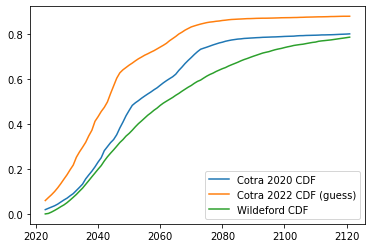

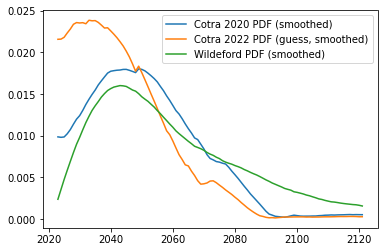

In [70]:
## TODO: Update all

cotra_2020_cdf = [0.0214, 0.0272, 0.0328, 0.0385, 0.0458, 0.0551, 0.0641, 0.0721,
       0.0827, 0.0923, 0.1061, 0.1199, 0.1343, 0.1574, 0.175 , 0.1917,
       0.2108, 0.2321, 0.251 , 0.2825, 0.3001, 0.3177, 0.3317, 0.3531,
       0.3829, 0.4089, 0.4372, 0.4606, 0.4829, 0.4944, 0.504 , 0.5147,
       0.5243, 0.5335, 0.5423, 0.5521, 0.5608, 0.5719, 0.5826, 0.5922,
       0.6011, 0.6096, 0.6209, 0.6379, 0.6524, 0.6682, 0.682 , 0.6948,
       0.7084, 0.7207, 0.7314, 0.7362, 0.7407, 0.7456, 0.7506, 0.755 ,
       0.7594, 0.7626, 0.7668, 0.7698, 0.7725, 0.7745, 0.7765, 0.7775,
       0.7793, 0.7801, 0.781 , 0.7818, 0.7827, 0.7833, 0.7843, 0.7847,
       0.7852, 0.7858, 0.7861, 0.7868, 0.7874, 0.7882, 0.7887, 0.7891,
       0.7895, 0.7908, 0.7916, 0.7918, 0.7926, 0.7929, 0.7933, 0.7936,
       0.7941, 0.7949, 0.795 , 0.7954, 0.7957, 0.7962, 0.7969, 0.7976,
       0.7981, 0.7987, 0.7996, 0.8002, 0.8004, 0.801 , 0.8015, 0.8021,
       0.8025, 0.8029, 0.8034, 0.8041, 0.8045, 0.8052, 0.8059, 0.806 ,
       0.8066, 0.8071, 0.8079, 0.8087, 0.8089, 0.8093, 0.8093, 0.8095,
       0.8105, 0.8109, 0.8114, 0.8118, 0.8128, 0.8132, 0.8139, 0.8139,
       0.8144, 0.8149, 0.8154, 0.8162, 0.8167, 0.8173, 0.8177, 0.8185,
       0.8196, 0.82  , 0.821 , 0.8217, 0.8224, 0.8233, 0.8244, 0.8247,
       0.8254, 0.8262, 0.8267, 0.8274, 0.8277, 0.8288, 0.8294, 0.8298,
       0.8305, 0.8318, 0.8328, 0.8335, 0.8343, 0.8347, 0.8351, 0.8361,
       0.837 , 0.8376, 0.8385, 0.8398, 0.8404, 0.8413, 0.8419, 0.8427,
       0.8437, 0.8448, 0.8458, 0.8462, 0.8471, 0.8482, 0.8487, 0.8491,
       0.8498, 0.8505, 0.8507, 0.8511, 0.8519, 0.8526, 0.8534, 0.8542,
       0.855 , 0.8554, 0.8559, 0.8565, 0.857 , 0.8575, 0.8581, 0.8587,
       0.8592, 0.86  , 0.8605, 0.861 , 0.8615, 0.862 , 0.8629]
cotra_2020_pdf = np.append(np.array(cotra_2020_cdf[0]), np.diff(cotra_2020_cdf[:len(bins)]))
cotra_2020_pdf_smoothed = savitzky_golay(cotra_2020_pdf[:len(bins)], 51, 3)

cotra_2022_cdf = [0.0616, 0.0747, 0.0873, 0.1015, 0.118 , 0.1365, 0.1564, 0.1758,
       0.1981, 0.2188, 0.2531, 0.2768, 0.2975, 0.3193, 0.3481, 0.3728,
       0.4124, 0.433 , 0.4557, 0.4742, 0.4981, 0.5348, 0.569 , 0.6032,
       0.627 , 0.6404, 0.6507, 0.6611, 0.6701, 0.6801, 0.6893, 0.697 ,
       0.7051, 0.7115, 0.7186, 0.7252, 0.7331, 0.7411, 0.749 , 0.7577,
       0.7691, 0.7785, 0.7881, 0.799 , 0.807 , 0.8161, 0.8233, 0.8303,
       0.8348, 0.839 , 0.8429, 0.8462, 0.8494, 0.8517, 0.8532, 0.8553,
       0.8566, 0.8588, 0.8602, 0.862 , 0.8633, 0.864 , 0.8648, 0.8654,
       0.8662, 0.867 , 0.8672, 0.8677, 0.8683, 0.8686, 0.8689, 0.8689,
       0.8692, 0.8695, 0.8699, 0.8703, 0.8709, 0.8711, 0.8713, 0.8715,
       0.8719, 0.8721, 0.8727, 0.873 , 0.8736, 0.8739, 0.8742, 0.8746,
       0.875 , 0.8751, 0.8754, 0.8757, 0.8763, 0.8764, 0.8768, 0.8772,
       0.8775, 0.8775, 0.8776, 0.8779, 0.878 , 0.8781, 0.8783, 0.8789,
       0.8792, 0.8794, 0.8795, 0.8798, 0.8805, 0.8808, 0.8814, 0.8819,
       0.8822, 0.8826, 0.8827, 0.8828, 0.8832, 0.8834, 0.8837, 0.8839,
       0.8842, 0.8848, 0.8857, 0.8859, 0.8861, 0.8863, 0.8866, 0.8869,
       0.8869, 0.8873, 0.8878, 0.8889, 0.8896, 0.8904, 0.8906, 0.8911,
       0.8915, 0.892 , 0.8929, 0.8934, 0.8937, 0.8942, 0.8946, 0.8954,
       0.8959, 0.8963, 0.8969, 0.8972, 0.8975, 0.8984, 0.8988, 0.8993,
       0.8999, 0.9004, 0.9007, 0.9015, 0.9019, 0.9021, 0.9026, 0.9031,
       0.9037, 0.9041, 0.9048, 0.9054, 0.9057, 0.9062, 0.9067, 0.9075,
       0.9084, 0.9088, 0.909 , 0.9101, 0.9106, 0.9108, 0.9114, 0.9116,
       0.9121, 0.9127, 0.913 , 0.9137, 0.9144, 0.9147, 0.9154, 0.9159,
       0.9161, 0.9166, 0.9173, 0.9177, 0.9185, 0.9189, 0.9193, 0.9195,
       0.9195, 0.9198, 0.9204, 0.9205, 0.921 , 0.9216, 0.9221]
cotra_2022_pdf = np.append(np.array(cotra_2022_cdf[0]), np.diff(cotra_2022_cdf[:len(bins)]))
cotra_2022_pdf_smoothed = savitzky_golay(cotra_2022_pdf[:len(bins)], 51, 3)

peter_cdf = [0.0024, 0.0045, 0.0106, 0.0179, 0.0258, 0.0345, 0.0423, 0.0522,
       0.0638, 0.076 , 0.0885, 0.1028, 0.1165, 0.1332, 0.1498, 0.1669,
       0.1835, 0.2004, 0.2162, 0.2369, 0.2551, 0.2711, 0.2861, 0.3021,
       0.3184, 0.3314, 0.347 , 0.3589, 0.3729, 0.3882, 0.4022, 0.4142,
       0.4268, 0.4394, 0.4498, 0.4614, 0.471 , 0.4828, 0.4929, 0.5014,
       0.5097, 0.5179, 0.5275, 0.5359, 0.5456, 0.5545, 0.5634, 0.5711,
       0.5808, 0.5891, 0.5949, 0.6039, 0.6125, 0.6198, 0.6257, 0.6331,
       0.6392, 0.6453, 0.6503, 0.6571, 0.6629, 0.6684, 0.674 , 0.6803,
       0.6858, 0.6904, 0.6956, 0.7006, 0.7052, 0.7099, 0.7146, 0.7179,
       0.7209, 0.7253, 0.7293, 0.7325, 0.7352, 0.7388, 0.7421, 0.7448,
       0.7482, 0.7503, 0.7523, 0.7539, 0.7566, 0.7591, 0.7616, 0.7632,
       0.7667, 0.7685, 0.7699, 0.7714, 0.7729, 0.7749, 0.7769, 0.779 ,
       0.7808, 0.7829, 0.7849, 0.787 , 0.7878, 0.7895, 0.7902, 0.792 ,
       0.7931, 0.794 , 0.7952, 0.7967, 0.7981, 0.7993, 0.8003, 0.8021,
       0.8031, 0.8044, 0.8049, 0.8058, 0.8063, 0.8072, 0.8079, 0.8083,
       0.8091, 0.8096, 0.8101, 0.8111, 0.8116, 0.8126, 0.8131, 0.8142,
       0.815 , 0.8157, 0.8161, 0.817 , 0.8178, 0.8192, 0.8194, 0.8206,
       0.8209, 0.8211, 0.8217, 0.8221, 0.823 , 0.8234, 0.8237, 0.8245,
       0.825 , 0.8253, 0.8259, 0.8265, 0.8273, 0.8279, 0.8285, 0.8287,
       0.8294, 0.8297, 0.8302, 0.8302, 0.8311, 0.8315, 0.8316, 0.8318,
       0.832 , 0.8321, 0.8324, 0.8327, 0.8331, 0.8335, 0.8337, 0.8341,
       0.8342, 0.8344, 0.8347, 0.8349, 0.8353, 0.8359, 0.8365, 0.8371,
       0.8373, 0.8374, 0.8375, 0.8379, 0.8382, 0.8385, 0.8391, 0.8395,
       0.8398, 0.84  , 0.8406, 0.841 , 0.8413, 0.8417, 0.8419, 0.842 ,
       0.8426, 0.8427, 0.8432, 0.8434, 0.8439, 0.8444, 0.8448]
peter_pdf = np.append(np.array(peter_cdf[0]), np.diff(peter_cdf[:len(bins)]))
peter_pdf_smoothed = savitzky_golay(peter_pdf[:len(bins)], 51, 3)

plt.plot(bins[:99], cotra_2020_cdf[:99], label='Cotra 2020 CDF')
plt.plot(bins[:99], cotra_2022_cdf[:99], label='Cotra 2022 CDF (guess)')
plt.plot(bins[:99], peter_cdf[:99], label='Wildeford CDF')
plt.legend()
plt.show()

plt.plot(bins[:99], cotra_2020_pdf_smoothed[:99], label='Cotra 2020 PDF (smoothed)')
plt.plot(bins[:99], cotra_2022_pdf_smoothed[:99], label='Cotra 2022 PDF (guess, smoothed)')
plt.plot(bins[:99], peter_pdf_smoothed[:99], label='Wildeford PDF (smoothed)')
plt.legend()
plt.show()

## Sensitivity Analysis

In [89]:
print('## Default ##')
results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                      tai_flop_size_=36,
                                      nonscaling_delay_=0,
                                      algo_doubling_rate_=2,
                                      possible_algo_reduction_=2,
                                      initial_flops_per_dollar_=10 ** 18,
                                      flops_halving_rate_=2.5,
                                      max_flops_per_dollar_=10 ** 24,
                                      initial_pay_=10*M,
                                      gdp_growth_=1.03,
                                      max_gdp_frac_=1/1600,
                                      willingness_ramp_=1,
                                      spend_doubling_time_=2.5,
                                      initial_chance_of_nonscaling_issue_=0,
                                      final_chance_of_nonscaling_issue_=0,
                                      nonscaling_issue_bottom_year_=0,
                                      willingness_spend_horizon_=1,
                                      print_diagnostic=False), n=1000)
print('{}: {}'.format(t,
                      ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                       '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                       '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
          

## Default ##
50: [2067, 2067, 2067]


In [90]:
print('## Horizon Length in Cotra Anchor ##')
for t in range(0, 10):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=sample_cotra_anchor(horizon_length=sq.const(t)),
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/1600,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(t,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
          

## Horizon Length in Cotra Anchor ##
0: [2022, 2036, 2207]
1: [2023, 2039, '>2222']
2: [2025, 2044, '>2222']
3: [2026, 2047, '>2222']
4: [2029, 2053, '>2222']
5: [2031, 2061, '>2222']
6: [2034, 2067, '>2222']
7: [2036, 2103, '>2222']
8: [2040, 2156, '>2222']
9: [2044, '>2222', '>2222']


In [91]:
print('## Horizon Length - no Bayes Update ##')
for t in range(0, 10):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=sample_cotra_anchor(horizon_length=sq.const(t),
                                                                             bayes_update=None),
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/1600,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(t,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
          

## Horizon Length - no Bayes Update ##
0: [2022, 2036, '>2222']
1: [2022, 2039, '>2222']
2: [2023, 2043, '>2222']
3: [2025, 2047, '>2222']
4: [2028, 2054, '>2222']
5: [2032, 2062, '>2222']
6: [2035, 2068, '>2222']
7: [2035, 2089, '>2222']
8: [2040, 2169, '>2222']
9: [2043, '>2222', '>2222']


In [92]:
print('## TAI FLOP Size ##')
for t in range(20, 51):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=t,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/1600,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(t,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

## TAI FLOP Size ##
20: [2022, 2022, 2022]
21: [2022, 2022, 2022]
22: [2022, 2022, 2022]
23: [2022, 2022, 2022]
24: [2022, 2022, 2022]
25: [2023, 2023, 2023]
26: [2025, 2025, 2025]
27: [2028, 2028, 2028]
28: [2030, 2030, 2030]
29: [2033, 2033, 2033]
30: [2036, 2036, 2036]
31: [2040, 2040, 2040]
32: [2044, 2044, 2044]
33: [2048, 2048, 2048]
34: [2053, 2053, 2053]
35: [2060, 2060, 2060]
36: [2067, 2067, 2067]
37: [2091, 2091, 2091]
38: [2169, 2169, 2169]
39: ['>2222', '>2222', '>2222']
40: ['>2222', '>2222', '>2222']
41: ['>2222', '>2222', '>2222']
42: ['>2222', '>2222', '>2222']
43: ['>2222', '>2222', '>2222']
44: ['>2222', '>2222', '>2222']
45: ['>2222', '>2222', '>2222']
46: ['>2222', '>2222', '>2222']
47: ['>2222', '>2222', '>2222']
48: ['>2222', '>2222', '>2222']
49: ['>2222', '>2222', '>2222']
50: ['>2222', '>2222', '>2222']


In [93]:
print('## GDP Growth ##')
for g in range(0, 5):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1 + g/100,
                                          max_gdp_frac_=1/1600,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(1 + g / 100,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

## GDP Growth ##
1.0: [2077, 2077, 2077]
1.01: [2072, 2072, 2072]
1.02: [2069, 2069, 2069]
1.03: [2067, 2067, 2067]
1.04: [2066, 2066, 2066]


In [94]:
print('## Max GDP Frac ##')
for g in [1/(500*K), 1/(250*K), 1/(100*K), 1/(50*K), 1/(10*K), 5/(10*K),
          1/2000, 1/1500, 1/1000, 2/1000, 3/1000, 4/1000, 5/1000, 1/100,
          2/100, 3/100, 4/100]:
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=g,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(g,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

## Max GDP Frac ##
2e-06: [2208, 2208, 2208]
4e-06: [2184, 2184, 2184]
1e-05: [2153, 2153, 2153]
2e-05: [2130, 2130, 2130]
0.0001: [2080, 2080, 2080]
0.0005: [2068, 2068, 2068]
0.0005: [2068, 2068, 2068]
0.0006666666666666666: [2067, 2067, 2067]
0.001: [2066, 2066, 2066]
0.002: [2064, 2064, 2064]
0.003: [2063, 2063, 2063]
0.004: [2062, 2062, 2062]
0.005: [2062, 2062, 2062]
0.01: [2061, 2061, 2061]
0.02: [2060, 2060, 2060]
0.03: [2060, 2060, 2060]
0.04: [2060, 2060, 2060]


In [95]:
print('## Spend Doubling Time ##')
for d in range(0, 50):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/1600,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=1 + d / 10,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(1 + d / 10,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

## Spend Doubling Time ##
1.0: [2067, 2067, 2067]
1.1: [2067, 2067, 2067]
1.2: [2067, 2067, 2067]
1.3: [2067, 2067, 2067]
1.4: [2067, 2067, 2067]
1.5: [2067, 2067, 2067]
1.6: [2067, 2067, 2067]
1.7: [2067, 2067, 2067]
1.8: [2067, 2067, 2067]
1.9: [2067, 2067, 2067]
2.0: [2067, 2067, 2067]
2.1: [2067, 2067, 2067]
2.2: [2067, 2067, 2067]
2.3: [2067, 2067, 2067]
2.4: [2067, 2067, 2067]
2.5: [2067, 2067, 2067]
2.6: [2067, 2067, 2067]
2.7: [2068, 2068, 2068]
2.8: [2068, 2068, 2068]
2.9: [2068, 2068, 2068]
3.0: [2068, 2068, 2068]
3.1: [2068, 2068, 2068]
3.2: [2068, 2068, 2068]
3.3: [2069, 2069, 2069]
3.4: [2069, 2069, 2069]
3.5: [2069, 2069, 2069]
3.6: [2069, 2069, 2069]
3.7: [2070, 2070, 2070]
3.8: [2070, 2070, 2070]
3.9: [2071, 2071, 2071]
4.0: [2071, 2071, 2071]
4.1: [2071, 2071, 2071]
4.2: [2072, 2072, 2072]
4.3: [2072, 2072, 2072]
4.4: [2073, 2073, 2073]
4.5: [2073, 2073, 2073]
4.6: [2074, 2074, 2074]
4.7: [2074, 2074, 2074]
4.8: [2075, 2075, 2075]
4.9: [2076, 2076, 2076]
5.0: [2076, 20

In [96]:
print('## Initial FLOPs per dollar ##')
for d in [17, 17.5, 18]:
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** d,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/1600,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(d,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

## Initial FLOPs per dollar ##
17: [2075, 2075, 2075]
17.5: [2071, 2071, 2071]
18: [2067, 2067, 2067]


In [97]:
print('## Initial pay ##')
for p in range(70, 91):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10 ** (p / 10),
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/1600,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('${}: {}'.format(numerize(10 ** (p / 10)),
                           ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                            '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                            '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

## Initial pay ##
$10 million: [2067, 2067, 2067]
$13 million: [2067, 2067, 2067]
$16 million: [2067, 2067, 2067]
$20 million: [2067, 2067, 2067]
$25 million: [2067, 2067, 2067]
$32 million: [2067, 2067, 2067]
$40 million: [2067, 2067, 2067]
$50 million: [2067, 2067, 2067]
$63 million: [2067, 2067, 2067]
$79 million: [2067, 2067, 2067]
$100 million: [2067, 2067, 2067]
$126 million: [2067, 2067, 2067]
$158 million: [2067, 2067, 2067]
$200 million: [2067, 2067, 2067]
$251 million: [2067, 2067, 2067]
$316 million: [2067, 2067, 2067]
$398 million: [2067, 2067, 2067]
$501 million: [2067, 2067, 2067]
$631 million: [2067, 2067, 2067]
$794 million: [2067, 2067, 2067]
$1 billion: [2067, 2067, 2067]


In [98]:
print('## FLOPs halving rate ##')
for f in range(5, 41):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=f / 10,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/1600,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(f / 10,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

## FLOPs halving rate ##
0.5: [2049, 2049, 2049]
0.6: [2049, 2049, 2049]
0.7: [2049, 2049, 2049]
0.8: [2049, 2049, 2049]
0.9: [2049, 2049, 2049]
1.0: [2049, 2049, 2049]
1.1: [2049, 2049, 2049]
1.2: [2050, 2050, 2050]
1.3: [2051, 2051, 2051]
1.4: [2052, 2052, 2052]
1.5: [2053, 2053, 2053]
1.6: [2054, 2054, 2054]
1.7: [2055, 2055, 2055]
1.8: [2057, 2057, 2057]
1.9: [2058, 2058, 2058]
2.0: [2060, 2060, 2060]
2.1: [2061, 2061, 2061]
2.2: [2063, 2063, 2063]
2.3: [2064, 2064, 2064]
2.4: [2066, 2066, 2066]
2.5: [2067, 2067, 2067]
2.6: [2069, 2069, 2069]
2.7: [2071, 2071, 2071]
2.8: [2072, 2072, 2072]
2.9: [2074, 2074, 2074]
3.0: [2075, 2075, 2075]
3.1: [2077, 2077, 2077]
3.2: [2078, 2078, 2078]
3.3: [2080, 2080, 2080]
3.4: [2081, 2081, 2081]
3.5: [2083, 2083, 2083]
3.6: [2084, 2084, 2084]
3.7: [2086, 2086, 2086]
3.8: [2087, 2087, 2087]
3.9: [2088, 2088, 2088]
4.0: [2090, 2090, 2090]


In [99]:
print('## Max FLOPs per dollar ##')
for f in range(20, 31):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** f,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/1600,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(f,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

## Max FLOPs per dollar ##
20: ['>2222', '>2222', '>2222']
21: ['>2222', '>2222', '>2222']
22: [2169, 2169, 2169]
23: [2091, 2091, 2091]
24: [2067, 2067, 2067]
25: [2067, 2067, 2067]
26: [2067, 2067, 2067]
27: [2067, 2067, 2067]
28: [2067, 2067, 2067]
29: [2067, 2067, 2067]
30: [2067, 2067, 2067]


In [100]:
print('## Willingness ramp ##')
for r in range(1, 11):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/1600,
                                          willingness_ramp_=r / 10,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=1,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(r / 10,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

## Willingness ramp ##
0.1: [2060, 2060, 2060]
0.2: [2062, 2062, 2062]
0.3: [2063, 2063, 2063]
0.4: [2064, 2064, 2064]
0.5: [2065, 2065, 2065]
0.6: [2066, 2066, 2066]
0.7: [2066, 2066, 2066]
0.8: [2067, 2067, 2067]
0.9: [2067, 2067, 2067]
1.0: [2067, 2067, 2067]


In [101]:
print('## Willingness to spend horizon ##')
for y in range(1, 11):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/1600,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=y,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(y,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

## Willingness to spend horizon ##
1: [2067, 2067, 2067]
2: [2067, 2067, 2067]
3: [2066, 2066, 2066]
4: [2066, 2066, 2066]
5: [2066, 2066, 2066]
6: [2066, 2066, 2066]
7: [2066, 2066, 2066]
8: [2066, 2066, 2066]
9: [2066, 2066, 2066]
10: [2066, 2066, 2066]


In [102]:
print('## Algo doubling rate ##')
for d in range(10, 41, 2):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=d / 10,
                                          possible_algo_reduction_=2,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/1600,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=y,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(d / 10,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

## Algo doubling rate ##
1.0: [2066, 2066, 2066]
1.2: [2066, 2066, 2066]
1.4: [2066, 2066, 2066]
1.6: [2066, 2066, 2066]
1.8: [2066, 2066, 2066]
2.0: [2066, 2066, 2066]
2.2: [2066, 2066, 2066]
2.4: [2066, 2066, 2066]
2.6: [2066, 2066, 2066]
2.8: [2067, 2067, 2067]
3.0: [2067, 2067, 2067]
3.2: [2067, 2067, 2067]
3.4: [2067, 2067, 2067]
3.6: [2067, 2067, 2067]
3.8: [2067, 2067, 2067]
4.0: [2067, 2067, 2067]


In [103]:
print('## Possible algo reduction ##')
for r in range(0, 13):
    results = sq.sample(lambda: run_model(initial_gdp_=21*T,
                                          tai_flop_size_=36,
                                          nonscaling_delay_=0,
                                          algo_doubling_rate_=2,
                                          possible_algo_reduction_=r,
                                          initial_flops_per_dollar_=10 ** 18,
                                          flops_halving_rate_=2.5,
                                          max_flops_per_dollar_=10 ** 24,
                                          initial_pay_=10*M,
                                          gdp_growth_=1.03,
                                          max_gdp_frac_=1/1600,
                                          willingness_ramp_=1,
                                          spend_doubling_time_=2.5,
                                          initial_chance_of_nonscaling_issue_=0,
                                          final_chance_of_nonscaling_issue_=0,
                                          nonscaling_issue_bottom_year_=0,
                                          willingness_spend_horizon_=y,
                                          print_diagnostic=False), n=1000)
    print('{}: {}'.format(r,
                          ['>2222' if int(sq.get_percentiles(results)[5]) > 2222 else int(sq.get_percentiles(results)[5]),
                           '>2222' if int(sq.get_percentiles(results)[50]) > 2222 else int(sq.get_percentiles(results)[50]),
                           '>2222' if int(sq.get_percentiles(results)[95]) > 2222 else int(sq.get_percentiles(results)[95])]))
    

## Possible algo reduction ##
0: [2101, 2101, 2101]
1: [2075, 2075, 2075]
2: [2066, 2066, 2066]
3: [2059, 2059, 2059]
4: [2054, 2054, 2054]
5: [2052, 2052, 2052]
6: [2051, 2051, 2051]
7: [2051, 2051, 2051]
8: [2051, 2051, 2051]
9: [2051, 2051, 2051]
10: [2051, 2051, 2051]
11: [2051, 2051, 2051]
12: [2051, 2051, 2051]


In [104]:
# TODO: Wildeford meta anchor horizon length
# TODO: Wildeford meta anchor efficiency w/ efficiency-based algorithmic reduction
# TODO: efficiency-based algorithmic reduction vs. regular algorithmic reduction

In [105]:
get_question(11558)

ConnectionError: HTTPSConnectionPool(host='www.metaculus.com', port=443): Max retries exceeded with url: /api2/questions/11558 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x13051f820>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [88]:
# https://www.metaculus.com/questions/11558/maximum-compute-used-in-ai-training/
# TODO: Fetch from Metaculus, look side by side
# TODO: Be able to predict back
for y in [2022, 2025, 2030]:
    print('-')
    print('## {} ##'.format(y))
    for i in range(3):
        flops_at_max_ = flops_at_max(initial_gdp=variables['initial_gdp'],
                                     gdp_growth=[1.02, 1.025, 1.03][i],
                                     initial_pay=[10*M, 100*M, 1*B][i],
                                     spend_doubling_time=[1, 2, 3][i],
                                     max_gdp_frac=[1/1000, 4/1000, 1/100][i],
                                     initial_flops_per_dollar=10 ** 18,
                                     max_flops_per_dollar=10 ** 24,
                                     flops_halving_rate=[2, 2.5, 3][i],
                                     year=(y - CURRENT_YEAR))

        print('{}: {} max log FLOPs / ~{} petaFLOP/s-days)'.format(['25th', 'mean', '75th'][i],
                                                                   np.round(np.log10(flops_at_max_), 1),
                                                                   log_flop_to_petaflop_sdays(np.log10(flops_at_max_))))


-
## 2022 ##
25th: 25.0 max log FLOPs / ~115686 petaFLOP/s-days)
mean: 26.0 max log FLOPs / ~1156049 petaFLOP/s-days)
75th: 27.0 max log FLOPs / ~11519978 petaFLOP/s-days)
-
## 2025 ##
25th: 26.4 max log FLOPs / ~2609670 petaFLOP/s-days)
mean: 26.8 max log FLOPs / ~7497725 petaFLOP/s-days)
75th: 27.6 max log FLOPs / ~45901775 petaFLOP/s-days)
-
## 2030 ##
25th: 28.6 max log FLOPs / ~429961423 petaFLOP/s-days)
mean: 28.2 max log FLOPs / ~167592848 petaFLOP/s-days)
75th: 28.6 max log FLOPs / ~455905830 petaFLOP/s-days)
